# 1„ÄÅEnvironmental plot

## 1.0 Load data

In [1]:
from matplotlib import pyplot as plt
from function import *
from function.global_varibles import *
import glob
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import numpy as np


df_analysis=pd.read_csv(r'data\US_data\df_merged_data_for_analysis.csv')
df_economic = pd.read_csv('data/US_data/df_economic.csv')
df_analysis


# ÁéØÂ¢ÉÁª¥Â∫¶ÁöÑÂèòÈáè
env_data = df_analysis[['lat', 'lon', 'predicted_prob','gmm_density','sample_type']].copy()

# Á¢≥ÂáèÊéíÁª¥Â∫¶ÁöÑÂèòÈáè

emission_data = df_analysis[['lat', 'lon', 'Expectation_net_benefit_adjust','area_m2']].copy()
emission_data = emission_data.rename(columns={'Expectation_net_benefit_adjust': 'Expectation_net_benefit'})

# ÁªèÊµéÁª¥Â∫¶ÁöÑÂèòÈáè
economic_2050 = df_economic[df_economic['analysis_year'] == 2050]
avg_npv = economic_2050.groupby(['lat', 'lon'])['net_npv_usd'].mean().reset_index().rename(columns={'net_npv_usd': 'avg_npv'})


# ÂêàÂπ∂ÊâÄÊúâÂèòÈáè
merged_data_for_plot = env_data.merge(emission_data, on=['lat', 'lon'], how='outer') \
                      .merge(avg_npv, on=['lat', 'lon'], how='outer')


                      

gogogo
‚úÖ TensorFlow available
‚úÖ scikeras available
‚úÖ SHAP available


In [2]:
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO



us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')
us_counties = gpd.read_file('data/cb_2018_us_county_500k.shp')


us_nation_4326 = us_nation.to_crs('EPSG:4326')
us_states_4326 = us_states.to_crs('EPSG:4326')
us_counties_4326 = us_counties.to_crs('EPSG:4326')

# 2. ËØªÂèñDEMÂπ∂ËÆæÁΩÆCRSÔºàÂ¶ÇÊûúÁº∫Â§±Ôºâ
dem = rioxarray.open_rasterio(r'figure\draw_shp\DEM.nc', masked=True)

# Ê£ÄÊü•DEMÁöÑCRSÔºåÂ¶ÇÊûúÁº∫Â§±ÂàôÊâãÂä®ËÆæÁΩÆ
if dem.rio.crs is None:
    # Ê†πÊçÆDEMÊï∞ÊçÆÁöÑÂùêÊ†áËåÉÂõ¥Âà§Êñ≠ÔºåÈÄöÂ∏∏ÂÖ®ÁêÉDEM‰ΩøÁî®EPSG:4326
    print("DEM CRSÁº∫Â§±ÔºåËÆæÁΩÆ‰∏∫EPSG:4326")
    dem = dem.rio.write_crs("EPSG:4326")

# 3. Á°Æ‰øùUS nationÁöÑCRS‰∏éDEM‰∏ÄËá¥
if us_nation.crs != dem.rio.crs:
    print(f"ËΩ¨Êç¢US nation CRS‰ªé {us_nation.crs} Âà∞ {dem.rio.crs}")
    us_nation = us_nation.to_crs(dem.rio.crs)



# 4. Áî®us_nationÁ≤æÁ°ÆË£ÅÂâ™DEM
print("ÂºÄÂßãË£ÅÂâ™DEMÔºà‰ΩøÁî®us_nationÔºâ...")
dem_us = dem.rio.clip(us_nation.geometry.apply(mapping), us_nation.crs, drop=True)
print("DEMË£ÅÂâ™ÂÆåÊàêÔºÅ")





DEM CRSÁº∫Â§±ÔºåËÆæÁΩÆ‰∏∫EPSG:4326
ËΩ¨Êç¢US nation CRS‰ªé EPSG:4269 Âà∞ EPSG:4326
ÂºÄÂßãË£ÅÂâ™DEMÔºà‰ΩøÁî®us_nationÔºâ...
DEMË£ÅÂâ™ÂÆåÊàêÔºÅ


## 1.1 Help funciton

In [64]:

def _render_terrain(ax, dem_data, usa_bounds_main, transformer):
    """Ê∏≤ÊüìÂú∞ÂΩ¢"""
    qm = None
    dem_lon = dem_data.x.values
    dem_lat = dem_data.y.values
    lon_mask = (dem_lon >= usa_bounds_main['lon_min']) & (dem_lon <= usa_bounds_main['lon_max'])
    lat_mask = (dem_lat >= usa_bounds_main['lat_min']) & (dem_lat <= usa_bounds_main['lat_max'])
    
    if lon_mask.any() and lat_mask.any():
        lon_idx = np.where(lon_mask)[0]
        lat_idx = np.where(lat_mask)[0]
        
        # ÊäΩÁ®ÄÊ†ÖÊ†º
        step_x = max(1, len(lon_idx)//1800)
        step_y = max(1, len(lat_idx)//900)
        lon_sub = lon_idx[::step_x]
        lat_sub = lat_idx[::step_y]
        elev = dem_data.squeeze().values[np.ix_(lat_sub, lon_sub)]

        mask = ~np.isnan(elev)
        if mask.any():
            lo = np.nanpercentile(elev, 35)
            elev[elev < lo] = np.nan

            # Âú∞ÂΩ¢ÈÖçËâ≤
            terrain_colors = ListedColormap(["#ffffff", "#eef3ef", "#dfe8e0",
                                           "#d2ddcf", "#c7d1c1", "#b7c2af"])
            terrain_colors.set_bad((0, 0, 0, 0))
            qs = np.nanpercentile(elev, [35, 50, 65, 78, 88, 98])
            norm = BoundaryNorm(qs, terrain_colors.N)

            lon_grid, lat_grid = np.meshgrid(dem_lon[lon_sub], dem_lat[lat_sub])
            gx, gy = transformer.transform(lon_grid, lat_grid)            
            qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,
                              shading='auto', alpha=0.55, antialiased=False, zorder=1)
            qm.set_clip_on(True)
    
    return qm


def _draw_glow_outline_outside(ax, gdf_albers, line_color="#444444", line_width=0.8,
                              widths_km=(0, 30, 50), alphas=(0.95, 0.5, 0.3), 
                              colors=("#08336e", "#105ca4", "#3888c0")):
    """ÁªòÂà∂ÂõΩÁïåÁ∫øÂÖâÊôïÊïàÊûú"""
    g = gdf_albers.copy()
    geom = unary_union(g.geometry)
    
    if make_valid is not None:
        geom = make_valid(geom)
    else:
        geom = geom.buffer(0)

    radii_m = [k*1000.0 for k in widths_km]
    ordered = list(zip(radii_m, alphas, colors))
    ordered.sort(key=lambda x: x[0])

    last_inner = geom.buffer(0, join_style=2, cap_style=2)
    glow_meshes = []
    
    for i, (r, alpha, color) in enumerate(ordered):
        outer = geom.buffer(r, join_style=2, cap_style=2)
        ring = outer.difference(last_inner)
        if not ring.is_empty:
            glow_series = gpd.GeoSeries([ring], crs=g.crs)
            glow_mesh = glow_series.plot(ax=ax, color=color, alpha=alpha, edgecolor="none",
                                       zorder=8.2 + i*0.01)
            glow_meshes.append(glow_mesh)
        last_inner = outer

    g.boundary.plot(ax=ax, color=line_color, linewidth=line_width, zorder=9.6)
    return glow_meshes



def _draw_background_map(ax, usa_bounds_main):
    """ÁªòÂà∂ËÉåÊôØÂú∞Âõæ"""
    try:
        bbox_expanded = box(
            usa_bounds_main['lon_min'] - 3, usa_bounds_main['lat_min'] - 3,
            usa_bounds_main['lon_max'] + 3, usa_bounds_main['lat_max'] + 3
        )
        helper_gdf = gpd.read_file(r'figure\draw_shp\ne_110m_land.shp').to_crs(4326)
        helper_gdf = helper_gdf.clip(bbox_expanded)
        
        if 'featurecla' in helper_gdf.columns:
            helper_gdf = helper_gdf[helper_gdf['featurecla'].str.contains('Land', na=False)]
        
        if make_valid is not None:
            helper_gdf['geometry'] = helper_gdf.geometry.map(make_valid)
        else:
            helper_gdf['geometry'] = helper_gdf.geometry.buffer(0)
            
        helper_gdf = helper_gdf[helper_gdf.geometry.geom_type.isin(['Polygon', 'MultiPolygon'])]
        helper_gdf = helper_gdf.explode(index_parts=False, ignore_index=True)
        helper_gdf_proj = helper_gdf.to_crs('ESRI:102003')
        helper_gdf_proj['geometry'] = helper_gdf_proj.buffer(0)
        helper_gdf_proj.plot(ax=ax, facecolor='white', edgecolor='lightgray',
                           linewidth=0.3, alpha=1, zorder=0.5)
    except Exception as e:
        print(f"Helper map error: {e}")

def _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors):
    """Ê∑ªÂä†È¢úËâ≤Êù°Âà∞ËÉåÊôØÂú∞Âõæ‰∏ãÊñπÔºåÂπ∂Âú®‰∏äÊñπÊòæÁ§∫Êï∞ÊçÆÂàÜÂ∏ÉÊõ≤Á∫ø+Êü±Áä∂Âõæ"""
    def add_horizontal_cbar_equiv(fig, ax, mappable, var_bins, variable_name, unit_display=None, var_values=None, colors=None):
        # Ëé∑Âèñ‰∏ªÂú∞Âõæ‰ΩçÁΩÆ
        pos = ax.get_position()
        
        # colorbarÊîæÂú®Â∫ïÈÉ®ÔºåËÉåÊôØÂú∞Âõæ‰∏ãÊñπ
        left = pos.x0 + 0.2 * pos.width
        bottom = 0.1  # Âõ∫ÂÆöÂú®Â∫ïÈÉ®
        width = 0.55 * pos.width
        height = 0.035  # colorbarÈ´òÂ∫¶

        cax = fig.add_axes([left, bottom, width, height])
        cax.set_in_layout(False)
        cax.set_zorder(50)  
        cb = fig.colorbar(mappable, cax=cax, orientation='horizontal')

        cb.set_ticks(var_bins[1::2])

        # Ê†ºÂºèÂåñÂàªÂ∫¶Ê†áÁ≠æ
        tick_vals = var_bins[1::2]
        if variable_name == 'avg_npv':
            tick_labels = [f'{v/1_000_000:.2f}' for v in tick_vals]
        elif variable_name == 'predicted_prob':
            tick_labels = [f'{v:.2f}' for v in tick_vals]
        elif variable_name == 'Expectation_net_benefit':
            tick_labels = [f'{v/1_000:.2f}' for v in tick_vals]
        else:
            tick_labels = [f'{v:.0f}' for v in tick_vals]
        cb.set_ticklabels(tick_labels)

        # ÁªÜÈïø
        cax.tick_params(axis='x', which='major', length=2.5, width=0.5, pad=1, labelsize=5)
        cax.tick_params(axis='x', which='minor', length=1.5, width=0.4, label1On=False)
        cb.outline.set_linewidth(0.7)

        # ÁôæÂàÜ‰ΩçÊ†áÁ≠æ
        percentile_labels = [f'Top{p}' for p in range(10, 101, 20)][::-1]
        major_tick_locs = cb.get_ticks()
        for loc, label in zip(major_tick_locs, percentile_labels):
            # ‰ΩøÁî®colorbarÂùêÊ†áÁ≥ªÁªüÁöÑÊ≠£Á°ÆÂÆö‰ΩçÊñπÂºè
            x_disp = cax.transData.transform((loc, 0))[0]
            x_frac = cax.transAxes.inverted().transform((x_disp, 0))[0]
            cax.text(x_frac, 1.15, label, transform=cax.transAxes,
                    ha='center', va='bottom', fontsize=5, clip_on=False)
        cax.text(1.08, 1.3, "(%)", ha='center', va='bottom', fontsize=5, 
                fontweight='bold', transform=cax.transAxes)

        # ========== Ê∑ªÂä†Êï∞ÊçÆÂàÜÂ∏ÉÊõ≤Á∫øÂíåÊü±Áä∂Âõæ ==========
        chart_ax = None  # ÂàùÂßãÂåñ‰ª•‰æøÂêéÁª≠ÂºïÁî®
        if var_values is not None and colors is not None:
            # ÂàõÂª∫ÂõæË°®ÂùêÊ†áËΩ¥Ôºå‰ΩçÁΩÆÂú®colorbar‰∏äÊñπ
            chart_height = 0.11  # ÂõæË°®È´òÂ∫¶
            chart_bottom = bottom + height + 0.05  # Âú®colorbar‰∏äÊñπ
            
            chart_ax = fig.add_axes([left, chart_bottom, width, chart_height])
            chart_ax.set_in_layout(False)
            chart_ax.set_zorder(51)
            
            clean_values = var_values[~np.isnan(var_values)]
            if len(clean_values) > 0:
                # 1. ÁªòÂà∂Êü±Áä∂ÂõæÔºàÂ∫ïÂ±ÇÔºâ- ‰ΩøÁî®10%ÂàÜ‰ΩçÊï∞ÁªÑ
                # ÂÆö‰πâ10‰∏™ÂàÜ‰ΩçÊï∞ÁªÑ (0-10%, 10-20%, ..., 90-100%)
                percentiles = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                bin_edges = np.percentile(clean_values, percentiles)
                
                # ËÆ°ÁÆóÊØè‰∏™10%ÂàÜ‰ΩçÊï∞ÊÆµÁöÑÊï∞ÊçÆÂÄºÂíåÈ¢úËâ≤
                bar_heights = []
                bar_positions = []
                bar_colors = []
                bar_widths = []
                
                for i in range(10):
                    bin_min = bin_edges[i]
                    bin_max = bin_edges[i+1]
                    
                    # x‰ΩçÁΩÆ‰∏∫ËØ•ÂàÜ‰ΩçÊï∞ÊÆµÁöÑ‰∏≠Èó¥ÂÄºÔºàÁôæÂàÜÊØîÔºâ
                    bar_positions.append((percentiles[i] + percentiles[i+1]) / 2)
                    
                    # ËÆ°ÁÆóËØ•ÂàÜ‰ΩçÊï∞ÊÆµÁöÑÊï∞ÊçÆÂØÜÂ∫¶
                    count_in_bin = len(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    # yÂÄº‰∏∫ËØ•ÂàÜ‰ΩçÊï∞ÊÆµÁöÑÂπ≥ÂùáÊï∞ÂÄº
                    mean_value = np.mean(clean_values[(clean_values >= bin_min) & (clean_values <= bin_max)])
                    
                    # ÂΩí‰∏ÄÂåñyÂÄºÂà∞0-1ËåÉÂõ¥
                    y_norm = (mean_value - var_bins.min()) / (var_bins.max() - var_bins.min())
                    bar_heights.append(y_norm)
                    
                    # Êü±Â≠êÂÆΩÂ∫¶
                    bar_widths.append(10)  # ÊØè‰∏™Êü±Â≠êÂÆΩÂ∫¶‰∏∫10%
                    
                    # Á°ÆÂÆöÈ¢úËâ≤
                    bar_colors.append(colors[i])
                
                # ÁªòÂà∂Êü±Â≠êÔºàËÉåÊôØÔºâ
                for i in range(10):
                    chart_ax.bar(bar_positions[i], bar_heights[i], width=bar_widths[i],
                                color=bar_colors[i], alpha=0.4, edgecolor='none')
                
                # 2. ÁªòÂà∂Êõ≤Á∫øÔºàÈ°∂Â±ÇÔºâ- ‰ΩøÁî®ÊØè‰∏™binÁöÑ‰∏≠ÂøÉÁÇπ
                chart_ax.plot(bar_positions, bar_heights, color='#333333', linewidth=1.2, alpha=0.8, zorder=10)
                
                # ËÆæÁΩÆxËΩ¥ËåÉÂõ¥Ôºö0-100%ÔºàÂØπÂ∫î‰ºòÂÖàÁ∫ß/ÂàÜ‰ΩçÊï∞Ôºâ
                chart_ax.set_xlim(0, 100)
                chart_ax.set_ylim(0, 1.1)
                
                # 3. ÁßªÈô§xËΩ¥ÂàªÂ∫¶ÂíåÊ†áÁ≠æ
                chart_ax.set_xticks([])
                chart_ax.set_xticklabels([])
                
                # Âú®xËΩ¥Êú´Á´ØÔºà100%ÔºâÊ∑ªÂä†ÁæéËßÇÁöÑÂÆûÂøÉÁÆ≠Â§¥
                from matplotlib.patches import FancyArrowPatch


                # ÂàõÂª∫‰∏Ä‰∏™ÂÆûÂøÉÔºà‰∏âËßíÂΩ¢ÔºâÁÆ≠Â§¥Ôºåarrowstyle='simple'
                arrow_solid = FancyArrowPatch(
                    posA=(97, 0), posB=(100, 0),
                    transform=chart_ax.get_xaxis_transform(),  
                    arrowstyle='simple',
                    color='black', linewidth=0, mutation_scale=8, zorder=20
                )
                arrow_solid.set_clip_on(False)
                chart_ax.add_patch(arrow_solid)



            
            # ÁßªÈô§È°∂ÈÉ®Âíå‰æßËæπËæπÊ°Ü
            chart_ax.spines['top'].set_visible(False)
            chart_ax.spines['right'].set_visible(False)
            chart_ax.spines['left'].set_visible(False)
            chart_ax.set_yticks([])
            chart_ax.patch.set_visible(False)
            
            # Ê∑ªÂä†ËôöÁ∫øÂºïÁ∫øËøûÊé•colorbarÁöÑtick‰ΩçÁΩÆÂà∞Êï∞ÊçÆÂàÜÂ∏ÉÂõæÁöÑÂØπÂ∫î‰ΩçÁΩÆ
            if chart_ax is not None and clean_values is not None and len(clean_values) > 0:
                from matplotlib.lines import Line2D
                
                # ËÆ°ÁÆóÊØè‰∏™major_tick_locÂØπÂ∫îÁöÑÁôæÂàÜ‰ΩçÊï∞ÂÄº
                for loc in major_tick_locs:
                    # ÊâæÂà∞locÂØπÂ∫îÁöÑÊï∞ÂÄºÂú®Êï∞ÊçÆ‰∏≠ÁöÑÁôæÂàÜ‰ΩçÊï∞
                    pct = (np.sum(clean_values <= loc) / len(clean_values)) * 100
                    
                    # ÂºïÁ∫øÁöÑËµ∑ÁÇπÂíåÁªàÁÇπxÂùêÊ†áÈÉΩ‰ΩøÁî®colorbarÁöÑÂàªÂ∫¶‰ΩçÁΩÆÔºàÁ°Æ‰øùÂûÇÁõ¥Á∫øÔºâ
                    # Â∞ÜlocËΩ¨Êç¢‰∏∫figureÂùêÊ†á
                    x_tick_display, _ = cax.transData.transform((loc, 0))
                    x_tick_fig, _ = fig.transFigure.inverted().transform((x_tick_display, 0))
                    
                    # Ëµ∑ÁÇπÁöÑyÂùêÊ†áÔºàcolorbarÈ°∂ÈÉ®Ôºâ
                    y_start = cax.get_position().y1
                    
                    # ÁªàÁÇπÁöÑyÂùêÊ†áÔºàÊï∞ÊçÆÂàÜÂ∏ÉÂõæÂ∫ïÈÉ®Ôºâ
                    y_end = chart_ax.get_position().y0
                    
                    # ÁªòÂà∂ÂûÇÁõ¥Á∫øÔºàËµ∑ÁÇπÂíåÁªàÁÇπÁöÑxÂùêÊ†áÁõ∏ÂêåÔºâ
                    line = Line2D([x_tick_fig, x_tick_fig], [y_start, y_end],
                                transform=fig.transFigure, color="gray", 
                                lw=0.8, alpha=0.4, linestyle='--', zorder=45)
                    fig.add_artist(line)

        for ch in cax.get_children():
            try:
                ch.set_clip_path(cax.patch)
            except Exception:
                pass

        return cax, cb

    # ÊéßÂà∂Âçï‰ΩçÊ†áÁ≠æ
    if variable_name == 'net_npv_usd':
        unit_display = f'{unit} (10‚Å∂)'
    elif variable_name == 'Expectation_net_benefit':
        unit_display = f'{unit} (10¬≥)'
    else:
        unit_display = f'{unit} '

    cbar_ax, cbar = add_horizontal_cbar_equiv(fig, ax, scatter, var_bins, variable_name, unit_display, var_values, colors)
    cbar_ax.text(1.05, -0.3, unit_display, ha='left', va='top', fontsize=5, 
                fontweight='bold', transform=cbar_ax.transAxes)

def _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv):
    """ÁªòÂà∂ÁªèÁ∫¨Â∫¶ÁΩëÊ†ºÔºåÊ†áÁ≠æÊòæÁ§∫Âú®‰∏äÊñπÂíåÂè≥ÊñπÔºàÊõ≤Á∫øÁΩëÊ†ºÔºâ"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    # ËΩ¥Ê°Ü‰∏éÂõõËæπ
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)

    # Ëé∑ÂèñÁªèÁ∫¨Â∫¶ËåÉÂõ¥
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # ÁªèÂ∫¶ÂàªÂ∫¶ÂíåÁΩëÊ†ºÁ∫øÔºàÊõ≤Á∫øÔºâ
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # Âè™ÁªòÂà∂Âú∞ÂõæÂÜÖÁöÑÊõ≤Á∫øÁΩëÊ†ºÁ∫øÔºåË£ÅÂâ™Âà∞Âú∞ÂõæÂå∫Âüü
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # Âè™Âú®È°∂ÈÉ®ËæπÁïåÂØªÊâæ‰∫§ÁÇπ
        top_edge = LineString([(xmin, ymax), (xmax, ymax)])
        intersection = line.intersection(top_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                xticks.append(intersection.x)
                ax.text(intersection.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}¬∞W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # Â¶ÇÊûú‰∫§ÁÇπÊúâÂ§ö‰∏™ÔºåÈÄâÊã©ÊúÄÂ∑¶‰æßÁöÑ
                points = list(intersection.geoms)
                if points:
                    x_coords = [p.x for p in points]
                    min_x_idx = np.argmin(x_coords)
                    xticks.append(points[min_x_idx].x)
                    ax.text(points[min_x_idx].x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}¬∞W",
                           ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                                   edgecolor='none'))

    # Á∫¨Â∫¶ÂàªÂ∫¶ÂíåÁΩëÊ†ºÁ∫øÔºàÊõ≤Á∫øÔºâ
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # Âè™ÁªòÂà∂Âú∞ÂõæÂÜÖÁöÑÊõ≤Á∫øÁΩëÊ†ºÁ∫ø
        clip_line = line.intersection(frame)
        if not clip_line.is_empty and clip_line.geom_type == 'LineString':
            coords = list(clip_line.coords)
            if len(coords) > 1:
                coords_array = np.array(coords)
                ax.plot(coords_array[:,0], coords_array[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # Âè™Âú®Â∑¶‰æßËæπÁïåÂØªÊâæ‰∫§ÁÇπ
        left_edge = LineString([(xmin, ymin), (xmin, ymax)])
        intersection = line.intersection(left_edge)
        
        if not intersection.is_empty:
            if intersection.geom_type == 'Point':
                yticks.append(intersection.y)
                ax.text(xmin - (xmax - xmin) * 0.02, intersection.y, f"{int(round(lat))}¬∞N",
                       ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                               edgecolor='none'))
            elif intersection.geom_type == 'MultiPoint':
                # Â¶ÇÊûú‰∫§ÁÇπÊúâÂ§ö‰∏™ÔºåÈÄâÊã©‰∏≠Èó¥ÁöÑ
                points = list(intersection.geoms)
                if points:
                    mid_idx = len(points) // 2
                    yticks.append(points[mid_idx].y)
                    ax.text(xmin - (xmax - xmin) * 0.02, points[mid_idx].y, f"{int(round(lat))}¬∞N",
                           ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                           bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                                   edgecolor='none'))
    """ÁªòÂà∂ÁªèÁ∫¨Â∫¶ÁΩëÊ†ºÔºåÊ†áÁ≠æÊòæÁ§∫Âú®‰∏äÊñπÂíåÂ∑¶‰æßÔºàÊõ≤Á∫øÁΩëÊ†ºÔºåÂéªÈô§Âè≥‰æßÊ†áÁ≠æÔºâ"""
    def extent_lonlat_from_axes(ax, pad_deg=3):
        xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
        xs = np.linspace(xmin, xmax, 512)
        ys = np.linspace(ymin, ymax, 512)
        
        b_lon, b_lat = proj_inv.transform(xs, np.full_like(xs, ymin))
        t_lon, t_lat = proj_inv.transform(xs, np.full_like(xs, ymax))
        l_lon, l_lat = proj_inv.transform(np.full_like(ys, xmin), ys)
        r_lon, r_lat = proj_inv.transform(np.full_like(ys, xmax), ys)
        
        lon_min = np.nanmin([b_lon.min(), t_lon.min(), l_lon.min(), r_lon.min()]) - pad_deg
        lon_max = np.nanmax([b_lon.max(), t_lon.max(), l_lon.max(), r_lon.max()]) + pad_deg
        lat_min = np.nanmin([b_lat.min(), t_lat.min(), l_lat.min(), r_lat.min()]) - pad_deg
        lat_max = np.nanmax([b_lat.max(), t_lat.max(), l_lat.max(), r_lat.max()]) + pad_deg
        
        return (lon_min, lon_max), (lat_min, lat_max)

    def _project_xy(xy):
        xs, ys = proj_fwd.transform(xy[:,0], xy[:,1])
        return np.column_stack([xs, ys])

    def _choose_point_on_edge(geom):
        if geom.is_empty:
            return None
        if geom.geom_type == "Point":
            return geom
        if geom.geom_type.startswith("Multi") or geom.geom_type == "GeometryCollection":
            pts = [g for g in getattr(geom, "geoms", []) if g.geom_type == "Point"]
            return pts[0] if pts else None
        if geom.geom_type == "LineString":
            return geom.interpolate(0.5, normalized=True)
        return None

    # ËΩ¥Ê°Ü‰∏éÂõõËæπ
    xmin, xmax = ax.get_xlim(); ymin, ymax = ax.get_ylim()
    frame = box(xmin, ymin, xmax, ymax)
    left = LineString([(xmin, ymin), (xmin, ymax)])
    right = LineString([(xmax, ymin), (xmax, ymax)])  
    bottom = LineString([(xmin, ymin), (xmax, ymin)])
    top = LineString([(xmin, ymax), (xmax, ymax)])

    # Ëé∑ÂèñÁªèÁ∫¨Â∫¶ËåÉÂõ¥
    lon_ext, lat_ext = extent_lonlat_from_axes(ax, pad_deg=3)

    # ÁªèÂ∫¶ÂàªÂ∫¶ÂíåÁΩëÊ†ºÁ∫øÔºàÊõ≤Á∫øÔºâ
    xticks = []
    for i, lon in enumerate(lon_ticks):
        lats = np.linspace(lat_ext[0], lat_ext[1], 1000)
        xy = _project_xy(np.column_stack([np.full_like(lats, lon), lats]))
        line = LineString(xy)

        # ÁªòÂà∂Êõ≤Á∫øÁΩëÊ†ºÁ∫ø
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # Âú®È°∂ÈÉ®ÊòæÁ§∫Ê†áÁ≠æ
        p = _choose_point_on_edge(line.intersection(top))
        if p is None:
            p = _choose_point_on_edge(line.intersection(bottom))
        if p is not None:
            # Ê£ÄÊü•‰∏éÂ∑≤ÊúâÊ†áÁ≠æÁöÑÊúÄÂ∞èË∑ùÁ¶ª
            min_distance = 0.02 * (ax.get_xlim()[1] - ax.get_xlim()[0])
            if not xticks or min([abs(p.x - x) for x in xticks]) > min_distance:
                xticks.append(p.x)
                # Âú®‰∏äÊñπÊòæÁ§∫Ê†áÁ≠æ
                ax.text(p.x, ymax + (ymax - ymin) * 0.02, f"{abs(int(round(lon)))}¬∞W",
                       ha='center', va='bottom', fontsize=5, zorder=20, color='#666666',
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7, 
                               edgecolor='none'))

    # Á∫¨Â∫¶ÂàªÂ∫¶ÂíåÁΩëÊ†ºÁ∫øÔºàÊõ≤Á∫øÔºâ
    yticks = []
    for lat in lat_ticks:
        lons = np.linspace(lon_ext[0], lon_ext[1], 1000)
        xy = _project_xy(np.column_stack([lons, np.full_like(lons, lat)]))
        line = LineString(xy)

        # ÁªòÂà∂Êõ≤Á∫øÁΩëÊ†ºÁ∫ø
        ax.plot(xy[:,0], xy[:,1], lw=0.3, color="#cfcfcf", zorder=0.6, alpha=0.7)

        # Âè™Âú®Â∑¶‰æßÊòæÁ§∫Ê†áÁ≠æÔºà‰∏çÂú®Âè≥‰æßÔºâ
        p = _choose_point_on_edge(line.intersection(left))
        if p is not None:
            yticks.append(p.y)
            ax.text(xmin - (xmax - xmin) * 0.02, p.y, f"{int(round(lat))}¬∞N",
                   ha='right', va='center', fontsize=5, zorder=20, color='#666666',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.7,
                           edgecolor='none'))

## 1.2 Single-variable function

In [65]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
from pyproj import Transformer
from shapely.geometry import box, LineString
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from shapely.ops import unary_union
try:
    from shapely import make_valid
except Exception:
    make_valid = None
import matplotlib as mpl
import matplotlib.ticker as mticker

def plot_single_variable(
    merged_data_for_plot, 
    us_states_gdf, 
    dem_data, 
    variable_name,
    title=None, 
    unit=None, 
    colors=None, 
    cmap_type='sequential',
    add_north_arrow_and_scalebar=True,
    add_embedding_points=False  
):
    """
    ÁªòÂà∂ÂçïÂèòÈáèÂú∞ÂõæÔºåÁÆÄÂåñÁâàÊú¨
    
    Parameters:
    -----------
    merged_data_for_plot : DataFrame
        ÂåÖÂê´ÁªèÁ∫¨Â∫¶ÂíåÂèòÈáèÊï∞ÊçÆÁöÑÊï∞ÊçÆÊ°Ü
    us_states_gdf : GeoDataFrame
        ÁæéÂõΩÂ∑ûÁïåÊï∞ÊçÆ
    dem_data : xarray.Dataset
        DEMÂú∞ÂΩ¢Êï∞ÊçÆ
    variable_name : str
        Ë¶ÅÁªòÂà∂ÁöÑÂèòÈáèÂêç
    title : str, optional
        ÂõæË°®Ê†áÈ¢ò
    unit : str, optional
        ÂèòÈáèÂçï‰Ωç
    colors : list, optional
        È¢úËâ≤ÂàóË°®
    cmap_type : str, default 'sequential'
        È¢úËâ≤Êò†Â∞ÑÁ±ªÂûã
    add_north_arrow_and_scalebar : bool, default True
        ÊòØÂê¶Ê∑ªÂä†ÊåáÂåóÈíàÂíåÊØî‰æãÂ∞∫
    add_embedding_points : bool, default False
        ÊòØÂê¶Ê∑ªÂä†ÂµåÂÖ•ÁÇπ
        
    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    
    # ==================== 1. ÂàùÂßãËÆæÁΩÆ ====================
    plt.rcParams.update({
        "font.family": "Arial",
        "pdf.fonttype": 42, 
        "ps.fonttype": 42,
        "axes.linewidth": 0.5, 
        "axes.edgecolor": "black",
        "ps.usedistiller": "ghostscript",
        "ps.distiller.res": 6000,
    })

    # ÂàõÂª∫Êõ¥Â§ßÁöÑÂõæÂΩ¢ÂíåÂùêÊ†áËΩ¥
    fig, ax = plt.subplots(1, 1, figsize=(85/25.4, 90/25.4))  
    ax.set_autoscale_on(False)
    fig.patch.set_facecolor('white')      
    ax.set_facecolor('#e6f3ff')

    # ==================== 2. Âú∞ÁêÜËæπÁïåËÆæÁΩÆ ====================
    usa_bounds_main = {'lon_min': -125, 'lon_max': -65, 'lat_min': 24, 'lat_max': 51}
    bbox = box(usa_bounds_main['lon_min'], usa_bounds_main['lat_min'],
               usa_bounds_main['lon_max'], usa_bounds_main['lat_max'])
    
    # Â§ÑÁêÜÂ∑ûÁïåÊï∞ÊçÆ
    us_states_bound = us_states_gdf.to_crs(epsg=4326).clip(bbox)
    us_states_albers = us_states_bound.to_crs('ESRI:102003')
    
    # Â§ÑÁêÜÂõΩÁïåÁ∫ø
    us_nation_bound = us_nation.to_crs(epsg=4326).clip(bbox)
    us_nation_albers = us_nation_bound.to_crs('ESRI:102003')

    # ==================== 3. ÂùêÊ†áÂèòÊç¢ËÆæÁΩÆ ====================
    transformer = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)

    # ==================== 4. Âú∞ÂõæËåÉÂõ¥ËÆ°ÁÆó ====================
    xmin, ymin, xmax, ymax = us_states_albers.total_bounds

    # ÂáèÂ∞èËæπÁïåÔºåËÆ©ÂõæÂπÖÊõ¥Â§ß
    margin_x = (xmax - xmin) * 0.02  
    margin_y = (ymax - ymin) * 0.02
    colorbar_space = (ymax - ymin) * 0.05  
    
    xmin = xmin - margin_x
    xmax = xmax + margin_x
    ymin = ymin - margin_y - colorbar_space
    ymax = ymax + margin_y

    # ËÆæÁΩÆÂùêÊ†áËΩ¥‰ΩçÁΩÆÂíåËåÉÂõ¥ - ËÆ©ÂõæÂπÖÂ∞ΩÂèØËÉΩÂ§ß
    ax.set_position([0.07, 0.12, 0.9, 0.9])  
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # ==================== 5. Êï∞ÊçÆÂùêÊ†áËΩ¨Êç¢ ====================
    x_proj, y_proj = transformer.transform(merged_data_for_plot['lon'].values, 
                                          merged_data_for_plot['lat'].values)

    # ==================== 6. Âú∞ÂΩ¢Ê∏≤Êüì ====================
    qm = _render_terrain(ax, dem_data, usa_bounds_main, transformer)

    # ==================== 7. Âú∞ÂõæÂÖÉÁ¥†ÁªòÂà∂ ====================
    # ÁªòÂà∂ÂõΩÁïåÁ∫øÂÖâÊôïÊïàÊûú
    _draw_glow_outline_outside(ax, us_nation_albers)
    
    # ÁªòÂà∂Â∑ûÁïå
    us_states_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.4, alpha=0.4, zorder=9)

    # ==================== 8. ÂèñÊ∂àÂùêÊ†áËΩ¥ÂíåÁΩëÊ†º ====================
    # ÁßªÈô§ÂùêÊ†áËΩ¥ËæπÊ°Ü
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_visible(False)

    lon_ticks = np.arange(-115, -65, 10)
    lat_ticks = [ 25,35,45]
    
    # ÁªòÂà∂Êõ≤Á∫øÁΩëÊ†ºÁ∫øÔºàÊ†áÁ≠æÊòæÁ§∫Âú®‰∏äÊñπÔºâ
    proj_fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True)
    proj_inv = Transformer.from_crs("ESRI:102003", "EPSG:4326", always_xy=True)
    _draw_graticule_top_labels(ax, lon_ticks, lat_ticks, usa_bounds_main, proj_fwd, proj_inv)

    # ==================== 9. ËÉåÊôØÂú∞Âõæ ====================
    _draw_background_map(ax, usa_bounds_main)

    # ==================== 10. Êï∞ÊçÆÂèØËßÜÂåñ ====================
    var_values = np.round(np.asarray(merged_data_for_plot[variable_name].values, dtype=float), 3)
    var_bins = np.nanpercentile(var_values, [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    cmap = LinearSegmentedColormap.from_list(f"{variable_name}_cmap", colors, N=11)
    norm = BoundaryNorm(var_bins, ncolors=cmap.N)
    
    scatter = ax.scatter(x_proj, y_proj, c=var_values, cmap=cmap, norm=norm,
                        s=0.3, alpha=1, edgecolors='none', zorder=5)

    # ==================== 11. È¢úËâ≤Êù°Ôºà‰º†ÂÖ•var_valuesÁî®‰∫éÁªòÂà∂ÂàÜÂ∏ÉÂõæÔºâ====================
    _add_colorbar(fig, ax, scatter, var_bins, variable_name, unit, var_values, colors)
    # ==================== 12. ÊúÄÁªàÂ§ÑÁêÜ ====================
    fig.canvas.draw()          
    if qm is not None:
        qm.set_clip_path(ax.patch)
        qm.set_rasterized(True)

    return fig, ax

C:\Users\zpy10\AppData\Local\Temp\ipykernel_19832\716257876.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


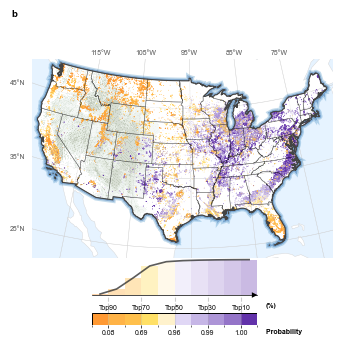

C:\Users\zpy10\AppData\Local\Temp\ipykernel_19832\716257876.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


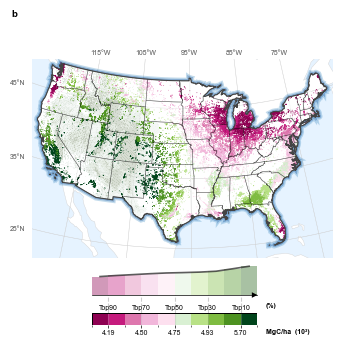

C:\Users\zpy10\AppData\Local\Temp\ipykernel_19832\716257876.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  qm = ax.pcolormesh(gx, gy, elev, cmap=terrain_colors, norm=norm,


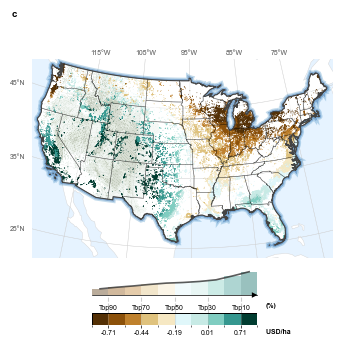

ÊâÄÊúâÂõæÁâáÁîüÊàêÂÆåÊàêÔºÅ


In [66]:

# ==================== ‰∏ªÁ®ãÂ∫è ====================
# ÂÆö‰πâ‰∏â‰∏™ÂèòÈáèÁöÑÂèÇÊï∞
variables_config = [
    {
        'name': 'predicted_prob',
        'title': 'Environmental Potential',
        'unit': 'Probability',
        'colors': [
            '#ff9933','#ffb347' ,'#ffc04c', '#ffe066',  '#fff2cc',
            '#e0d7f5','#c6b6e6','#ad95d7','#9474c8','#7b53b9','#6232aa'
        ],
        'filename': 'environmental score'
    },
    {
        'name': 'Expectation_net_benefit', 
        'title': 'Carbon Mitigation Potential',
        'unit': 'MgC/ha ',
        'colors': [
            '#8e0152', '#c51b7d', '#de77ae', '#f1b6da', '#fde0ef',
            '#d9f0d3', '#b8e186', '#7fbc41', '#4d9221', '#276419', '#00441b'
        ],
        'filename': 'carbon_mitigation_potential'
    },
    {
        'name': 'avg_npv',
        'title': 'Economic Potential', 
        'unit': 'USD/ha',
        'colors': [
            '#543005', '#8c510a', '#bf812d', '#dfc27d', '#f6e8c3',
            '#e0f7fa', '#c7eae5', '#80cdc1', '#35978f', '#01665e', '#003c30'
        ],
        'filename': 'economic_potential'
    }
]

# ÁîüÊàê‰∏â‰∏™ÂçïÁã¨ÁöÑÂõæ
panel_labels = ['b', 'b', 'c']

for i, var_config in enumerate(variables_config):
    try:
        add_north_arrow_and_scalebar = (i == 0)
        add_embedding_points = False

        fig, ax = plot_single_variable(
            merged_data_for_plot, 
            us_states_4326, 
            dem_us,
            var_config['name'],
            var_config['title'],
            var_config['unit'],
            var_config['colors'],
            add_north_arrow_and_scalebar=add_north_arrow_and_scalebar,
            add_embedding_points=add_embedding_points
        )

        fig.text(0.01, 0.99, panel_labels[i], ha='left', va='top', fontsize=7, fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.7, pad=0.2, lw=0), zorder=100)

        # ‰øùÂ≠òÂõæÁâá
        filename_png = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.png"
        filename_pdf = f"figure/US_figure/{var_config['filename']}_nature_style_300dpi.pdf"
        
        fig.savefig(filename_png, dpi=300, facecolor='White')  
        fig.canvas.draw()
        fig.savefig(filename_pdf, dpi=300, facecolor='None')                       

        plt.show()
        plt.close(fig)

    except Exception as e:
        print(e)
        continue

print("ÊâÄÊúâÂõæÁâáÁîüÊàêÂÆåÊàêÔºÅ")

# 2„ÄÅÁéØÂ¢ÉËúÇÁ™ùÂõæ

Áé∞Âú®ÈúÄË¶ÅÁªòÂà∂‰∏Ä‰∏™ÂÖ®ÁæéÁéØÂ¢ÉÁªìÊûÑÂèòÈáèÁöÑËúÇÁ™ùÂõæÔºåË¶ÅÊ±Ç‰∏çÂêåÁöÑËúÇÁ™ùËÉΩÂ§üÊ†πÊçÆGMMÊâìÂàÜ‰ΩìÁé∞‰∏çÂêåÁöÑÁéØÂ¢ÉÁªìÊûÑ„ÄÇ

ËÆ°ÁÆóÊ®°ÂùóÔºö
‰∏ªË¶ÅÂàÜ‰∏∫GMMËØÑÂàÜ‰∏éÂ±ÇÊ¨°ËÅöÁ±ªËÆ°ÁÆóÊ®°Âùó„ÄÅUSËúÇÁ™ùËÅöÁ±ªÁîüÊàêÊ®°Âùó„ÄÅËúÇÁ™ùÂõæ‰æãÊò†Â∞ÑÊ®°Âùó

```Ê®°Âùó‰∏ÄÔºöUSËúÇÁ™ùËÅöÁ±ªÁîüÊàêÊ®°Âùó

Êï∞ÊçÆÊé•Âè£ÔºöÁî®xarrayÊâìÂºÄds_allÔºåÂÖ∂‰∏≠ÁöÑfeature_groupsÊâÄÊ∂âÂèäÂèòÈáèÊòØÂêÑ‰∏™variableÂêçÁß∞ÔºõËúÇÁ™ùÈù¢ÁßØ2500Âπ≥ÊñπÂÖ¨Èáå
ËÆ°ÁÆóÊâßË°åÔºö‰ª•ÂêÑ‰∏™ËúÇÁ™ù‰∏∫Âçï‰ΩçÔºåÁî®MeanËÅöÂêàÂêÑ‰∏™variable
Êï∞ÊçÆËæìÂá∫Ôºöfeature_groupsÂú®ÂêÑ‰∏™ËúÇÁ™ù‰ª•MeanËÅöÂêàÁîüÊàêÁöÑdataframeÊàñËÄÖjsonÔºåËÆ∞‰∏∫hex_groups_mean

```


```Ê®°Âùó‰∫åÔºöGMMËØÑÂàÜ‰∏éÂ±ÇÊ¨°ËÅöÁ±ªÊ®°Âùó

Êï∞ÊçÆÊé•Âè£ÔºöÂØºÂÖ•gmm_model_34c_fixed.pklÊ®°ÂûãÔºåÊ®°Âùó‰∏ÄÁîüÊàêÁöÑËúÇÁ™ùÊï∞ÊçÆÁªìÊûÑ
ËÆ°ÁÆóÊâßË°åÔºöÁ¨¨‰∏ÄÔºåÂèÇÁÖßplot_abandon_component_probabilitiesÁöÑÈÄªËæëÔºåÊ†πÊçÆËæìÂÖ•ÁöÑhex_groups_meanËÆ°ÁÆóÂêÑ‰∏™ËúÇÁ™ùÁöÑcomponentÊ¶ÇÁéá$P(z_{k}|x_{i})$ÔºåÂπ∂‰∏îÊ†πÊçÆComonet to cluster mapsËÅöÂêàÊàêClusterÁöÑÊ¶ÇÁéáÔºõÁ¨¨‰∫åÔºåÂêåÊó∂ÂèÇÁÖßplot_gmm_component_patternsÂáΩÊï∞‰∏≠feature_groupsÁöÑÊ®°ÂºèÊù°ÁöÑËÆ°ÁÆóÊñπÊ≥ïÔºåËÆ°ÁÆóËúÇÁ™ùÂÜÖÁöÑÊ†∑ÂºèÊù°ÁöÑÊØî‰æã
Êï∞ÊçÆËæìÂá∫ÔºöÂêÑ‰∏™ËúÇÁ™ùÂ±û‰∫éÂêÑ‰∏™ClusterÁöÑÊ¶ÇÁéá„ÄÅÂêÑ‰∏™ËúÇÁ™ùÁöÑÊ†∑ÂºèÊù°ÊØî‰æã

```


```Ê®°Âùó‰∏âÔºöËúÇÁ™ùÂõæ‰æãÊò†Â∞ÑÊ®°Âùó

Êï∞ÊçÆÊé•Âè£ÔºöÂêÑ‰∏™ËúÇÁ™ùÂ±û‰∫éÂêÑ‰∏™ClusterÁöÑÊ¶ÇÁéá
ËÆ°ÁÆóÊâßË°åÔºö‰∏ÄÂÖ±Êúâ4‰∏™ClusterÔºåÊåâÁÖßÊ¶ÇÁéáÂ§ßÂ∞èÊò†Â∞ÑËá™ÂÆö‰πâÁöÑÂõæ‰æãÔºåÂú®ÂêÑ‰∏™ËúÇÁ™ùÂÜÖÈÉ®Â°´ÂÖÖÂØπÂ∫îÁöÑÂõæ‰æã„ÄÇ
Ëøô‰∏™Âõæ‰æãÁöÑÂÜÖÂÆπ‰∏ªË¶ÅÂåÖÊã¨‰∏§ÂùóËÆæËÆ°ÁªÑÂàÜ
Á¨¨‰∏ÄÔºåÂúÜÂøÉClusterÈÉ®ÂàÜ
Âú®ÊØè‰∏™ËúÇÁ™ùÁöÑ‰∏≠ÂøÉÁîüÊàê‰∏Ä‰∏™ÂçäÂæÑrÁöÑÂúÜÔºàrÁöÑÂ§ßÂ∞èÁ∫¶‰∏∫ËúÇÁ™ùËæπÈïøÁöÑ1/3Ôºâ
‰∏≠Èó¥ÁöÑÂúÜÂøÉÈ¢úËâ≤‰ª£Ë°®‰∫ÜÂ±û‰∫éÂì™‰∏™ClusterÁöÑÊ¶ÇÁéáÊúÄÂ§ß
Á¨¨‰∫åÔºåÂë®Âõ¥ÂúÜÁöÑpatternÈÉ®ÂàÜ
ËÆ∞ÂΩïÂúÜÂøÉ+ÂçäÂæÑr‰ΩçÁΩÆÔºåÂú®2rÂ§ÑÁîüÊàêÂúÜÂΩ¢
ÂêÑ‰∏™ÂúÜÂΩ¢‰ª£Ë°®‰∫ÜÂêÑ‰∏™feature_groupsÁöÑË¥°ÁåÆ
Êï∞ÊçÆËæìÂá∫ÔºöÂêÑ‰∏™ËúÇÁ™ùÊâÄÂØπÂ∫îÁöÑÂõæ‰æã

```



ÁâπÂæÅËæìÂÖ•Ôºö
    feature_groups = {
        'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
        'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
        'Geographic': ['DEM', 'Slope', 'gdmp'],
        'Climatic': ['rsds', 'tas', 'wind'],
    }
    time ==2020-01-01

Comonet to cluster mapÔºö
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

GMMÊ®°ÂûãËæìÂÖ•Ôºö
gmm_model_34c_fixed.pkl

ÂåÖÂØºÂÖ•Ôºö
from function import *
C:\Dev\Landuse_Zhong_clean\function\gmm_training.py

## Load data

In [2]:
from function import *
from function.load_all_ds import load_all_ds
from function.gmm_training import CombinedPreprocessor  
import h3
import geopandas as gpd
import joblib
from shapely.geometry import Polygon, Point, box
from pyproj import Transformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load datasets
ds_all = load_all_ds()
gmm_pipeline = joblib.load('gmm_model_34c_fixed.pkl')

# Load US shapefiles
us_nation = gpd.read_file(r'data\US_data\cb_2018_us_nation_5m.shp')
us_states = gpd.read_file(r'data\cb_2018_us_state_500k.shp')

print(f"ds_all shape: {ds_all.dims if hasattr(ds_all, 'dims') else 'N/A'}")
print(f"GMM model loaded: {gmm_pipeline}")

gogogo
‚úÖ TensorFlow available
‚úÖ scikeras available
‚úÖ SHAP available


c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 43
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 174
  result = blockwise(
c:\Users\zpy10\anaconda3\envs\geo\Lib\site-packages\dask\array\core.py:4998: PerformanceWarning: Increasing number of chunks by factor of 14
  result = blockwise(
c:\Users\zpy10\anacon

ds_all shape: FrozenMappingWarningOnValuesAccess({'time': 31, 'lat': 21600, 'lon': 43200})
GMM model loaded: Pipeline(steps=[('preprocessor',
                 CombinedPreprocessor(categorical_features=['landcover'],
                                      numeric_features=['GDPpc', 'GDPtot',
                                                        'Population',
                                                        'Powerdist', 'DEM',
                                                        'Slope', 'GURdist',
                                                        'PrimaryRoad',
                                                        'SecondaryRoad',
                                                        'TertiaryRoad', 'tas',
                                                        'gdmp', 'rsds',
                                                        'wind'])),
                ('gmm',
                 GaussianMixture(covariance_type='diag', n_components=34,
                           

## Module 1: H3 Hexagonal Grid Generation and Data Aggregation


In [60]:
from tqdm.auto import tqdm

# Define feature groups
feature_groups = {
    'Socioeconomic': ['Population', 'GDPpc', 'GDPtot', 'GURdist'],
    'Infrastructure': ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad'],
    'Geographic': ['DEM', 'Slope', 'gdmp'],
    'Climatic': ['rsds', 'tas', 'wind'],
}

# Get all variable names
all_vars = []
for group, vars_list in feature_groups.items():
    all_vars.extend(vars_list)


all_vars.append('landcover')
print(f"\nAll variables with landcover ({len(all_vars)}): {all_vars}")
print("Feature groups defined:")
for group, vars_list in feature_groups.items():
    print(f"  {group}: {vars_list}")
print(f"\nAll variables ({len(all_vars)}): {all_vars}")

# Check what's available in ds_all
print(f"\nds_all available variables: {list(ds_all.data_vars) if hasattr(ds_all, 'data_vars') else 'N/A'}")

def create_h3_hexagons_optimized(us_boundary, ds_all, time='2020-01-01', resolution=7,
                                 max_workers=8, parallel=True):
    """
    ‰ºòÂåñÁâàÔºö‰ªÖÂØπÁæéÂõΩÊú¨Âúü(ÊúÄÂ§ßPolygon)ÂÅö H3 Ë¶ÜÁõñÔºõÂØπËêΩÂÖ•Á†îÁ©∂Âå∫ÁöÑÊâÄÊúâÊ†ÖÊ†ºÁÇπ‰∏ÄÊ¨°ÊÄßÂèñÊ†∑Âπ∂Êåâ hex ËÅöÂêà

    Parameters
    ----------
    us_boundary : GeoDataFrame Êàñ shapely (Multi)Polygon (EPSG:4326)
    ds_all      : xarray.DatasetÔºåÂåÖÂê´ all_vars ÊèêÂà∞ÁöÑÂèòÈáè
    time        : strÔºåÊó∂Èó¥ÂàáÁâá
    resolution  : intÔºåH3 ÂàÜËæ®ÁéáÔºà7~8 Â∏∏Áî®Ôºâ
    max_workers : intÔºåÂπ∂Ë°åÁ∫øÁ®ãÊï∞ÔºàÁî®‰∫éÂ§ßÊï∞ÊçÆÊó∂ÁöÑ H3 Êò†Â∞Ñ/Âá†‰ΩïÔºâ
    parallel    : boolÔºåÊòØÂê¶Âπ∂Ë°å

    Returns
    -------
    GeoDataFrame[hex_id, variables..., geometry, center*, ...]  (EPSG:4326)
    """
    import numpy as np
    import pandas as pd
    import geopandas as gpd
    from shapely.geometry import Polygon, MultiPolygon, Point
    from shapely.ops import transform as shp_transform
    from concurrent.futures import ThreadPoolExecutor

    # ---------- H3 ÂÖºÂÆπÂØºÂÖ• ----------
    try:
        import h3  # ÂèØËÉΩÊòØ v4
        _H3_V4 = hasattr(h3, "polyfill_geojson") or hasattr(h3, "polygon_to_cells") or hasattr(h3, "latlng_to_cell")
    except ImportError:
        h3 = None
        _H3_V4 = False

    try:
        from h3 import h3 as h3_legacy  # v3 ÊóßÊé•Âè£
        _H3_V3 = True
    except ImportError:
        h3_legacy = None
        _H3_V3 = False

    if not (_H3_V4 or _H3_V3):
        raise ImportError("No usable H3 found. Install with `pip install h3`.")

    def _rings_of_polygon(poly: Polygon):
        # GeoJSON ÈúÄË¶Å (lon, lat)
        ext = [(x, y) for x, y in poly.exterior.coords]
        holes = [[(x, y) for x, y in r.coords] for r in poly.interiors]
        return [ext] + holes

    def _geojson_coords(geom):
        if geom.geom_type == "Polygon":
            return _rings_of_polygon(geom)  # [ext, hole1, ...]
        elif geom.geom_type == "MultiPolygon":
            return [_rings_of_polygon(p) for p in geom.geoms]  # [[ext,...], [ext,...], ...]
        else:
            raise TypeError(f"Unsupported geometry type: {geom.geom_type}")

    # H3 Â∞ÅË£ÖÔºöÁÇπ -> cell
    def H3_latlng_to_cell(lat, lon, res):
        if _H3_V4 and hasattr(h3, "latlng_to_cell"):
            return h3.latlng_to_cell(lat, lon, res)
        if _H3_V3 and hasattr(h3_legacy, "geo_to_h3"):
            return h3_legacy.geo_to_h3(lat, lon, res)
        raise RuntimeError("No latlng_to_cell / geo_to_h3 available in your H3.")

    # H3 Â∞ÅË£ÖÔºöPolygon/MultiPolygon -> cells
    from shapely.geometry import mapping

    def H3_cover_from_geom(geom, res):
        """
        ÁîüÊàêÂÖ≠ËæπÂΩ¢Ë¶ÜÁõñÔºåÂÖºÂÆπ H3 v4 ‰∏é v3„ÄÇ
        - v4: Êé•Âèó GeoJSON dictÔºà(lon,lat)Ôºâ
        - v3: Êé•ÂèóÁéØÂùêÊ†áÂàóË°®Ôºà(lat,lon)ÔºâÔºå‰∏çÊé•Âèó dict
        """
        # ---- v4 ‰ºòÂÖàÔºöpolyfill_geojson / polygon_to_cells ----
        if _H3_V4:
            gj = mapping(geom)  # Ê†áÂáÜ GeoJSON dictÔºåÂùêÊ†á‰∏∫ (lon,lat)
            # Êúâ‰∫õ v4 Âè™ÊúâÂÖ∂‰∏≠‰∏Ä‰∏™ÂáΩÊï∞ÔºåÊåâÂèØÁî®ÊÄßË∞ÉÁî®
            if hasattr(h3, "polyfill_geojson"):
                return set(h3.polyfill_geojson(gj, res))
            if hasattr(h3, "polygon_to_cells"):
                return set(h3.polygon_to_cells(gj, res))
            # ÁªßÁª≠Â∞ùËØï v3
            # (‰∏çË¶Å raiseÔºåËøôÈáåËÆ©ÂÆÉËµ∞Âà∞ v3 ÂàÜÊîØ)
        
        # ---- v3Ôºöpolyfill ÈúÄË¶Å (lat,lon) ÁöÑÁéØÂàóË°®Ôºå‰∏çÂêÉ dict ----
        if _H3_V3 and hasattr(h3_legacy, "polyfill"):
            def _rings_latlon(poly):
                # exterior + holesÔºå‰∏îÈ°∫Â∫èËΩ¨Êç¢‰∏∫ (lat,lon)
                ext = [(y, x) for (x, y) in poly.exterior.coords]
                holes = [[(y, x) for (x, y) in r.coords] for r in poly.interiors]
                return [ext] + holes

            cells = set()
            if geom.geom_type == "Polygon":
                rings = _rings_latlon(geom)
                cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            elif geom.geom_type == "MultiPolygon":
                for p in geom.geoms:
                    rings = _rings_latlon(p)
                    cells |= set(h3_legacy.polyfill(rings, res, geo_json_conformant=False))
            else:
                raise TypeError(f"Unsupported geometry type: {geom.geom_type}")
            return cells

        raise RuntimeError("No usable H3 cover function available (neither v4 polyfill_geojson/polygon_to_cells nor v3 polyfill).")


    # H3 Â∞ÅË£ÖÔºöcell ËæπÁïå / ‰∏≠ÂøÉÔºàÁªü‰∏ÄËæìÂá∫ (lon,lat)Ôºå‰∏ç‰º† geo_json=Ôºâ
    def H3_cell_boundary_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_boundary"):
            coords = h3.cell_to_boundary(cell)  # Â§öÊï∞ÁâàÊú¨Ëøî (lat, lon)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo_boundary"):
            coords = h3_legacy.h3_to_geo_boundary(cell)
        else:
            raise RuntimeError("No cell_to_boundary / h3_to_geo_boundary found.")
        return [(lon, lat) for (lat, lon) in coords]

    def H3_cell_center_lonlat(cell):
        if _H3_V4 and hasattr(h3, "cell_to_latlng"):
            lat, lon = h3.cell_to_latlng(cell)
        elif _H3_V3 and hasattr(h3_legacy, "h3_to_geo"):
            lat, lon = h3_legacy.h3_to_geo(cell)
        else:
            raise RuntimeError("No cell_to_latlng / h3_to_geo found.")
        return (lon, lat)

    from pyproj import Transformer
    from shapely.geometry import shape

    print(f"\n=== ‰ºòÂåñÁâàÔºöH3Ë¶ÜÁõñÊ≥ïÁîüÊàêÂÖ≠ËæπÂΩ¢ (ÂàÜËæ®Áéá {resolution}) ===")
    print("Step 1: ÁîüÊàêUSÂå∫ÂüüÁöÑH3ÂÖ≠ËæπÂΩ¢Ë¶ÜÁõñ...")

    # Áªü‰∏ÄËé∑ÂèñÂá†‰Ωï
    us_geom = us_boundary.geometry.iloc[0] if isinstance(us_boundary, gpd.GeoDataFrame) else us_boundary

    # ‰øÆÂ§çÂá†‰ΩïÔºàÈò≤Ëá™‰∫§Ôºâ
    try:
        from shapely.validation import make_valid
        us_geom = make_valid(us_geom)
    except Exception:
        us_geom = us_geom.buffer(0)

    # Âè™ÂèñÊúÄÂ§ß PolygonÔºàÂú®Á≠âÈù¢ÁßØÊäïÂΩ±‰∏ãÊã©‰ºòÔºâ
    if us_geom.geom_type == "MultiPolygon":
        print("  Ê£ÄÊµãÂà∞ MultiPolygonÔºåÈÄâÊã©Èù¢ÁßØÊúÄÂ§ßÁöÑÂ§öËæπÂΩ¢ÔºàÊú¨ÂúüÁæéÂõΩÔºâ...")
        fwd = Transformer.from_crs("EPSG:4326", "ESRI:102003", always_xy=True).transform
        areas = [shp_transform(fwd, p).area for p in us_geom.geoms]
        us_geom = list(us_geom.geoms)[int(np.argmax(areas))]
    elif us_geom.geom_type != "Polygon":
        raise ValueError(f"‰∏çÊîØÊåÅÁöÑÂú∞ÁêÜÁ±ªÂûã: {us_geom.geom_type}")

    print(f"  ‰ΩøÁî® PolygonÔºåÂ§ñÁéØÈ°∂ÁÇπÊï∞: {len(us_geom.exterior.coords)}")

    # Ë¶ÜÁõñÔºà‰∏•Ê†º API ÂÖºÂÆπÔºâ
    try:
        cells_list = list(H3_cover_from_geom(us_geom, resolution))
    except Exception as e:
        # ÊúÄÂêéÂÖúÂ∫ïÔºöbbox ÁΩëÊ†ºÈááÊ†∑Ë¶ÜÁõñÔºàÂ∞ΩÈáèÂ∞ëÁî®Ôºâ
        print(f"  ËßÑËåÉË¶ÜÁõñÂ§±Ë¥•Ôºö{e}")
        print("  ‰ΩøÁî®ÈôçÁ∫ßÊñπÊ°àÔºöbbox ÈááÊ†∑Ë¶ÜÁõñ ...")
        minx, miny, maxx, maxy = us_geom.bounds
        step_deg = 0.25
        lon_samples = np.arange(minx, maxx, step_deg)
        lat_samples = np.arange(miny, maxy, step_deg)
        # contains_xy (Shapely 2) / vectorized.contains (<=1.8) ÂÖºÂÆπ
        try:
            from shapely import contains_xy
            def _inside(lon, lat): return contains_xy(us_geom, lon, lat)
        except Exception:
            from shapely.vectorized import contains as vcontains
            def _inside(lon, lat): return vcontains(us_geom, lon, lat)
        cells = set()
        for lat in lat_samples:
            for lon in lon_samples:
                if _inside(lon, lat):
                    try:
                        cells.add(H3_latlng_to_cell(lat, lon, resolution))
                    except Exception:
                        pass
        cells_list = list(cells)

    print(f"  ÁîüÊàê‰∫Ü {len(cells_list):,} ‰∏™ÂÖ≠ËæπÂΩ¢ÂçïÂÖÉ")

    # ---------- Step 2: ÂêëÈáèÂåñÁªüËÆ°ÔºàÂú®Á†îÁ©∂Âå∫ÂÜÖÁöÑÊâÄÊúâÊ†ÖÊ†ºÁÇπ -> hex -> groupby meanÔºâ ----------
    print("\nStep 2: ÂØπÁ†îÁ©∂Âå∫Ê†ÖÊ†ºÁÇπÂêëÈáèÂåñÂèñÊ†∑ÔºåÂπ∂Êåâ hex ËÅöÂêà...")

    # ÈÄâÊã©Êó∂Èó¥ÂàáÁâá
    ds_slice = ds_all.sel(time=time) if "time" in ds_all.coords else ds_all

    # ÊèêÂèñÁªèÁ∫¨Â∫¶ÂùêÊ†á
    if hasattr(ds_slice, 'lon') and hasattr(ds_slice, 'lat'):
        lons = np.asarray(ds_slice.lon.values)
        lats = np.asarray(ds_slice.lat.values)
    elif hasattr(ds_slice, 'longitude') and hasattr(ds_slice, 'latitude'):
        lons = np.asarray(ds_slice.longitude.values)
        lats = np.asarray(ds_slice.latitude.values)
    else:
        raise ValueError("Cannot find lon/lat coords in ds_all")

    # Âè™Âú®ÁæéÂõΩÊú¨Âúü bbox ÂÜÖÊûÑÁΩëÊ†ºÔºåÂÜçÁ≤æÁ≠õÂà∞Èù¢ÂÜÖ
    minx, miny, maxx, maxy = us_geom.bounds
    if lons.ndim == 1 and lats.ndim == 1 and (np.all(np.diff(lons)>=0) and np.all(np.diff(lats)>=0)):
        i0 = max(0, np.searchsorted(lons, minx, side='left'))
        i1 = min(len(lons), np.searchsorted(lons, maxx, side='right'))
        j0 = max(0, np.searchsorted(lats, miny, side='left'))
        j1 = min(len(lats), np.searchsorted(lats, maxy, side='right'))
        sub_lons = lons[i0:i1]
        sub_lats = lats[j0:j1]
        xx, yy = np.meshgrid(sub_lons, sub_lats, indexing='xy')
    else:
        xx, yy = np.meshgrid(lons, lats, indexing='xy') if lons.ndim==1 else (lons, lats)

    # contains_xy / vectorized.contains ÂÖºÂÆπ
    try:
        from shapely import contains_xy
        mask = contains_xy(us_geom, xx, yy)
    except Exception:
        from shapely.vectorized import contains as vcontains
        mask = vcontains(us_geom, xx, yy)

    xs = xx[mask].ravel()
    ys = yy[mask].ravel()
    print(f"  Èù¢ÂÜÖÊ†ÖÊ†ºÁÇπ: {xs.size:,}")

    # ‰∏ÄÊ¨°ÊÄßÊèíÂÄºÊâÄÊúâÂèòÈáèÔºànearestÔºâ
    sampled = ds_slice[all_vars].interp(
        lon=('points', xs), lat=('points', ys), method='nearest'
    ).to_array('variable')  # (variable, points)

    data_matrix = sampled.transpose('points', 'variable').values  # ndarray
    var_names = sampled['variable'].values

    # ÁÇπ -> hexÔºàÂèØÂπ∂Ë°åÔºâ
    def _map_chunk(idx):
        return [H3_latlng_to_cell(ys[i], xs[i], resolution) for i in idx]

    if parallel and xs.size > 50_000:
        chunks = np.array_split(np.arange(xs.size), max_workers)
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            parts = list(ex.map(_map_chunk, chunks))
        hex_ids = np.fromiter((h for p in parts for h in p), dtype=object, count=xs.size)
    else:
        hex_ids = np.fromiter((H3_latlng_to_cell(lat, lon, resolution) for lon, lat in zip(xs, ys)),
                              dtype=object, count=xs.size)

    # Âè™‰øùÁïôÂú®Ë¶ÜÁõñÈõÜ‰∏≠ÁöÑ hex
    cover_set = set(cells_list)
    keep = np.fromiter((h in cover_set for h in hex_ids), dtype=bool, count=hex_ids.size)
    hex_ids = hex_ids[keep]
    data_matrix = data_matrix[keep, :]

    # Âú®ËÅöÂêàÈÉ®ÂàÜÔºàÁ¨¨279-294Ë°åÔºâÊõøÊç¢‰∏∫Ôºö

    numeric_vars = [v for v in var_names if v != 'landcover']
    categorical_vars = ['landcover'] if 'landcover' in var_names else []

    # Ëá™ÂÆö‰πâËÅöÂêàÂáΩÊï∞
    def q75_no_zero(x):
        """ËÆ°ÁÆóÈùûÈõ∂ÂÄºÁöÑ75%ÂàÜ‰ΩçÊï∞"""
        clean_x = x[x > 0]
        if len(clean_x) == 0:
            return 0
        return np.percentile(clean_x, 75)

    agg_dict = {var: 'mean' for var in numeric_vars}

    # PowerdistÂíåGURdist‰ΩøÁî®75%ÂàÜ‰ΩçÊï∞ÔºàÂéªÈô§0ÂÄºÔºâ
    if 'Powerdist' in numeric_vars:
        agg_dict['Powerdist'] = q75_no_zero
    if 'GURdist' in numeric_vars:
        agg_dict['GURdist'] = q75_no_zero

    if categorical_vars:
        agg_dict.update({var: lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0] 
                    for var in categorical_vars})

    # ËÅöÂêà
    df_points = pd.DataFrame(data_matrix, columns=var_names)
    df_points['hex_id'] = hex_ids

    # ÁªüËÆ°0ÂÄº
    print("\n  ÂéüÂßãÊ†ÖÊ†ºÁÇπÁöÑ0ÂÄºÁªüËÆ°:")
    for var in ['Powerdist', 'GURdist']:
        if var in df_points.columns:
            zero_count = (df_points[var] == 0).sum()
            total = len(df_points)
            print(f"    {var}: {zero_count:,}/{total:,} ({zero_count/total*100:.1f}%) ‰∏™ÁÇπ=0")

    print("\n  ËøáÊª§ÊéâPowerdistÂíåGURdist‰∏∫0ÁöÑÁÇπ...")
    initial_count = len(df_points)

    # ËøáÊª§Powerdist=0ÁöÑÁÇπ
    df_points = df_points[df_points['Powerdist'] > 1000]

    # ËøáÊª§GURdist=0ÁöÑÁÇπ  
    df_points = df_points[df_points['GURdist'] > 1000]

    removed_count = initial_count - len(df_points)
    print(f"    ÁßªÈô§ {removed_count:,} ‰∏™ÁÇπÔºàPowerdistÊàñGURdist=0Ôºâ")
    print(f"    ‰øùÁïô {len(df_points):,} ‰∏™ÁÇπÁî®‰∫éËÅöÂêà")

    df_hex = df_points.groupby('hex_id', sort=False, observed=True).agg(agg_dict).reset_index()
    # ÁªüËÆ°ËÅöÂêàÂêéÁöÑÁªìÊûú
    print("\n  ËÅöÂêàÂêéÂÖ≠ËæπÂΩ¢ÁöÑ0ÂÄºÁªüËÆ°:")
    for var in ['Powerdist', 'GURdist']:
        if var in df_hex.columns:
            zero_count = (df_hex[var] == 0).sum()
            total = len(df_hex)
            non_zero = df_hex[var][df_hex[var] > 0]
            print(f"    {var}: {zero_count}/{total} ({zero_count/total*100:.1f}%) ‰∏™ÂÖ≠ËæπÂΩ¢=0")
            if len(non_zero) > 0:
                print(f"      ÈùûÈõ∂ÂÄº: min={non_zero.min():.1f}, max={non_zero.max():.1f}, mean={non_zero.mean():.1f}")

    print(f"\n  ËÅöÂêàÂæóÂà∞ hex Êï∞Èáè: {len(df_hex):,}")

    # ---------- Step 3: ÊûÑÈÄ†Âá†‰ΩïÔºàÂèØÂπ∂Ë°åÔºâ ----------
    print("\nStep 3: ÊûÑÈÄ†ÂÖ≠ËæπÂΩ¢Âá†‰Ωï‰∏é‰∏≠ÂøÉÁÇπ ...")

    def _geom_center(hid):
        ring = H3_cell_boundary_lonlat(hid)  # (lon,lat)
        poly = Polygon(ring)
        cx, cy = H3_cell_center_lonlat(hid)  # (lon,lat)
        return poly, Point(cx, cy), cy, cx

    ids = df_hex['hex_id'].tolist()
    if parallel and len(ids) > 3_000:
        with ThreadPoolExecutor(max_workers=max_workers) as ex:
            results = list(ex.map(_geom_center, ids))
    else:
        results = [_geom_center(h) for h in ids]

    geoms, centers, center_lats, center_lons = zip(*results)

    # ÁªÑË£Ö GeoDataFrame
    out = df_hex.copy()
    out['geometry']   = list(geoms)
    out['center']     = list(centers)
    out['center_lat'] = center_lats
    out['center_lon'] = center_lons

    hex_gdf = gpd.GeoDataFrame(out, geometry='geometry', crs='EPSG:4326')
    if 'landcover' in hex_gdf.columns:
        hex_gdf['landcover'] = hex_gdf['landcover'].astype(int)

    

    print(f"\n‚úÖ ÊàêÂäüÂàõÂª∫ GeoDataFrame: {len(hex_gdf):,} ‰∏™ÂÖ≠ËæπÂΩ¢")
    print(f"   Á©∫Èó¥ËåÉÂõ¥: {hex_gdf.total_bounds}")
    print(f"\nÊï∞ÊçÆÈ¢ÑËßà:\n{hex_gdf.head()}")

    return hex_gdf


# ÂàõÂª∫ÂÖ≠ËæπÂΩ¢Ë¶ÜÁõñÔºà‰ΩøÁî®‰ºòÂåñÊñπÊ≥ïÔºâ
hex_gdf = create_h3_hexagons_optimized(us_nation, ds_all, time='2020-01-01', resolution=8)



All variables with landcover (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']
Feature groups defined:
  Socioeconomic: ['Population', 'GDPpc', 'GDPtot', 'GURdist']
  Infrastructure: ['Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad']
  Geographic: ['DEM', 'Slope', 'gdmp']
  Climatic: ['rsds', 'tas', 'wind']

All variables (15): ['Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover']

ds_all available variables: ['abandonment_year', 'abandonment_duration', 'recultivation', 'current_abandonment', 'landcover', 'DEM', 'gdmp', 'GDPpc', 'GDPtot', 'GURdist', 'landcover_at_abandonment', 'Population', 'Powerdist', 'PrimaryRoad', 'rsds', 'SecondaryRoad', 'Slope', 'tas', 'TertiaryRoad', 'wind']

=== ‰ºòÂåñÁâàÔºöH3Ë¶ÜÁõñÊ≥ïÁîüÊàêÂÖ≠ËæπÂΩ¢ (ÂàÜËæ®Áéá 8) ===
S

### Data check

In [55]:
def clip_data_with_us_states(df, us_states_gdf, lon_col='lon', lat_col='lat'):
    """
    ‰ΩøÁî®ÁæéÂõΩÂ∑ûÁïå shapefile Ââ™Ë£ÅÁÇπÊï∞ÊçÆÔºõÂÖºÂÆπ‰∏çÂêåÁâàÊú¨ÁöÑ geopandas ÂèÇÊï∞Âêç
    """
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')
    us_states_4326 = us_states_gdf.to_crs('EPSG:4326')

    try:
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', predicate='within')
    except TypeError:
        # ÊóßÁâàÊú¨ geopandas ‰ΩøÁî® op ÂèÇÊï∞
        clipped = gpd.sjoin(gdf, us_states_4326, how='inner', op='within')

    # Ê∏ÖÁêÜ shapefile ÈôÑÂä†Â≠óÊÆµ
    clipped = clipped.drop(columns=['geometry', 'index_right'], errors='ignore')
    for col in us_states_gdf.columns:
        if col in clipped.columns:
            clipped = clipped.drop(columns=[col], errors='ignore')
    return clipped

usa_bounds_main = dict(lon_min=-125, lon_max=-65, lat_min=25, lat_max=49)


df_abandon = load_abandon(PATHS['us_abandon'])
df_embedding = load_embedding(PATHS['us_pv_embedding'])
df_net_benefit = pd.read_csv('data/US_data/df_net_benefit.csv')

# ÂàùÊ≠•ÁªèÁ∫¨Â∫¶ËåÉÂõ¥ËøáÊª§
df_embedding = df_embedding[
    (df_embedding['lon'] >= usa_bounds_main['lon_min']) &
    (df_embedding['lon'] <= usa_bounds_main['lon_max']) &
    (df_embedding['lat'] >= usa_bounds_main['lat_min']) &
    (df_embedding['lat'] <= usa_bounds_main['lat_max'])
]

# Á¨¨‰∫åÊ¨°Áî®Â∑ûÁïåÁü¢ÈáèÊõ¥Á≤æÁ°ÆË£ÅÂâ™
df_abandon = clip_data_with_us_states(df_abandon, us_states)
df_embedding = clip_data_with_us_states(df_embedding, us_states)

# ---------------------------
# 2) Áº∫Â§±ÂÄºÂ°´ÂÖÖ + ÂéªÈáç
# ---------------------------
df_abandon_fill   = fill_nonpositive_with_nearest(df_abandon)
df_embedding_fill = fill_nonpositive_with_nearest(df_embedding)

df_abandon_filtered = filter_duplicates(df_abandon_fill, df_embedding_fill)
df_abandon_filtered=df_abandon_filtered.merge(df_net_benefit[['lon', 'lat', 'area_m2']], on=['lat', 'lon'], how='left')
features_no_coords = [f for f in (NUMERIC_FEATURES + CAT_COLS) if f not in ['lat', 'lon']]
features_no_coords = [c for c in features_no_coords if c in df_embedding_fill.columns]

You want to predict the year: 2020.0
Âàó GDPpc Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº
Âàó GURdist Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº
Âàó GDPpc Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº
Âàó GURdist Ê≤°ÊúâÈúÄË¶ÅÂ°´ÂÖÖÁöÑÈùûÊ≠£ÂÄºÊàñNaNÂÄº


In [66]:
df_abandon_fill['Powerdist'].min()

622545.0

In [61]:
def comprehensive_three_way_comparison(df_embedding, df_abandon, hex_gdf, gmm_pipeline):
    """
    ÁªºÂêàÂØπÊØîdf_embeddingÔºàËÆ≠ÁªÉÁî®Ê≠£Ê†∑Êú¨Ôºâ„ÄÅdf_abandonÔºàÊíÇËçíÂú∞Ê†∑Êú¨Ôºâ„ÄÅhex_gdfÔºàÂÖ≠ËæπÂΩ¢ËÅöÂêàÊï∞ÊçÆÔºâ
    ËØäÊñ≠‰∏∫‰ªÄ‰πàhex_gdfÂÖ®ÈÉ®ÂΩíÂà∞Component 27
    """
    import pandas as pd
    import numpy as np
    from scipy.stats import ks_2samp
    from collections import Counter
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    all_features = numeric_features + categorical_features
    
    print("="*90)
    print("                     ‰∏âÊï∞ÊçÆÈõÜÁªºÂêàÂØπÊØîËØäÊñ≠Êä•Âëä")
    print("="*90)
    
    # ===== 1. Êï∞ÊçÆÈõÜÂü∫Á°Ä‰ø°ÊÅØ =====
    print(f"\n„Äê1„ÄëÊï∞ÊçÆÈõÜËßÑÊ®°")
    print(f"{'Êï∞ÊçÆÈõÜ':<15} {'Ê†∑Êú¨Êï∞':<12} {'Á©∫Èó¥Ë¶ÜÁõñ':<40} {'ËØ¥Êòé'}")
    print("-"*90)
    print(f"{'df_embedding':<15} {len(df_embedding):<12} {'USÂÖ®ÂüüÁÇπÊï∞ÊçÆ':<40} {'ËÆ≠ÁªÉÁî®Ê≠£Ê†∑Êú¨'}")
    print(f"{'df_abandon':<15} {len(df_abandon):<12} {'USÂÖ®ÂüüÁÇπÊï∞ÊçÆ':<40} {'ÊµãËØïÁî®ÊíÇËçíÂú∞'}")
    print(f"{'hex_gdf':<15} {len(hex_gdf):<12} {'USÂÖ®ÂüüÂÖ≠ËæπÂΩ¢Ë¶ÜÁõñ':<40} {'ËÅöÂêàÊï∞ÊçÆ'}")
    
    # ===== 2. ÂÖ≥ÈîÆÁâπÂæÅÁªüËÆ°ÂØπÊØî =====
    print(f"\n„Äê2„ÄëÂÖ≥ÈîÆÁâπÂæÅÁªüËÆ°ÂØπÊØîÔºàPowerdist & GURdistÔºâ")
    print(f"{'ÁâπÂæÅ':<12} {'Êï∞ÊçÆÈõÜ':<12} {'ÂùáÂÄº':<12} {'Ê†áÂáÜÂ∑Æ':<12} {'ÊúÄÂ∞èÂÄº':<12} {'ÊúÄÂ§ßÂÄº':<12}")
    print("-"*80)
    
    key_features = ['Powerdist', 'GURdist', 'GDPpc', 'Population']
    for feat in key_features:
        if feat in numeric_features:
            print(f"\n{feat}:")
            
            # df_embeddingÁªüËÆ°
            if feat in df_embedding.columns:
                embed_mean = df_embedding[feat].mean()
                embed_std = df_embedding[feat].std()
                embed_min = df_embedding[feat].min()
                embed_max = df_embedding[feat].max()
                print(f"  {'df_embedding':<12} {embed_mean:<12.2f} {embed_std:<12.2f} {embed_min:<12.2f} {embed_max:<12.2f}")
            
            # df_abandonÁªüËÆ°
            if feat in df_abandon.columns:
                abandon_mean = df_abandon[feat].mean()
                abandon_std = df_abandon[feat].std()
                abandon_min = df_abandon[feat].min()
                abandon_max = df_abandon[feat].max()
                print(f"  {'df_abandon':<12} {abandon_mean:<12.2f} {abandon_std:<12.2f} {abandon_min:<12.2f} {abandon_max:<12.2f}")
            
            # hex_gdfÁªüËÆ°
            if feat in hex_gdf.columns:
                hex_mean = hex_gdf[feat].mean()
                hex_std = hex_gdf[feat].std()
                hex_min = hex_gdf[feat].min()
                hex_max = hex_gdf[feat].max()
                print(f"  {'hex_gdf':<12} {hex_mean:<12.2f} {hex_std:<12.2f} {hex_min:<12.2f} {hex_max:<12.2f}")
    
    # ===== 3. Ê†áÂáÜÂåñÂêéÁöÑÁâπÂæÅÂàÜÂ∏É =====
    print(f"\n„Äê3„ÄëÊ†áÂáÜÂåñÂêéÁöÑÁâπÂæÅÂàÜÂ∏É")
    
    # ËΩ¨Êç¢Êï∞ÊçÆ
    embed_transformed = preprocessor.transform(df_embedding[all_features])
    abandon_transformed = preprocessor.transform(df_abandon[all_features])
    hex_transformed = preprocessor.transform(hex_gdf[all_features])
    
    feature_names = preprocessor.get_feature_names_out()
    
    print(f"{'ÁâπÂæÅ':<12} {'df_embeddingÂùáÂÄº':<20} {'df_abandonÂùáÂÄº':<20} {'hex_gdfÂùáÂÄº':<20}")
    print("-"*80)
    
    for i, feat in enumerate(numeric_features[:8]):  # Âè™ÊòæÁ§∫Ââç8‰∏™
        if i < len(feature_names):
            embed_mean = embed_transformed[:, i].mean()
            abandon_mean = abandon_transformed[:, i].mean()
            hex_mean = hex_transformed[:, i].mean()
            
            print(f"{feat:<12} {embed_mean:>10.3f}¬±{embed_transformed[:, i].std():>6.3f}  "
                  f"{abandon_mean:>10.3f}¬±{abandon_transformed[:, i].std():>6.3f}  "
                  f"{hex_mean:>10.3f}¬±{hex_transformed[:, i].std():>6.3f}")
    
    # ÂÖ≥ÈîÆÔºöPowerdistÂíåGURdistÁöÑ‰ΩçÁΩÆ
    if 'Powerdist' in numeric_features:
        idx = numeric_features.index('Powerdist')
        print(f"\n‚ö†Ô∏è PowerdistÊ†áÂáÜÂåñÂêé:")
        print(f"  df_embedding: {embed_transformed[:, idx].mean():.3f}")
        print(f"  df_abandon:   {abandon_transformed[:, idx].mean():.3f}")
        print(f"  hex_gdf:      {hex_transformed[:, idx].mean():.3f}")
        print(f"  ‚Üí hex_gdfÂÅèÁ¶ª: {abs(hex_transformed[:, idx].mean() - embed_transformed[:, idx].mean()):.2f} Ê†áÂáÜÂ∑Æ")
    
    # ===== 4. GMM ComponentÂàÜÂ∏ÉÂØπÊØî =====
    print(f"\n„Äê4„ÄëGMM ComponentÊ¶ÇÁéáÂàÜÂ∏É")
    
    # ËÆ°ÁÆóÂêÑÁªÑ‰ª∂ÁöÑÊ¶ÇÁéá
    embed_probs = gmm.predict_proba(embed_transformed)
    abandon_probs = gmm.predict_proba(abandon_transformed)
    hex_probs = gmm.predict_proba(hex_transformed)
    
    # ÊâæÂà∞dominant component
    embed_dominant = np.argmax(embed_probs, axis=1)
    abandon_dominant = np.argmax(abandon_probs, axis=1)
    hex_dominant = np.argmax(hex_probs, axis=1)
    
    # ÁªüËÆ°
    embed_counts = Counter(embed_dominant)
    abandon_counts = Counter(abandon_dominant)
    hex_counts = Counter(hex_dominant)
    
    print(f"  Unique components:")
    print(f"    df_embedding: {len(embed_counts)} ‰∏™")
    print(f"    df_abandon:   {len(abandon_counts)} ‰∏™")
    print(f"    hex_gdf:      {len(hex_counts)} ‰∏™")
    
    # ÊòæÁ§∫ÂêÑÊï∞ÊçÆÈõÜÁöÑ‰∏ªË¶Åcomponents
    print(f"\n  ÂêÑÊï∞ÊçÆÈõÜDominant ComponentÂàÜÂ∏ÉÔºàTop 10Ôºâ:")
    print(f"  {'Component':<12} {'df_embedding':<15} {'df_abandon':<15} {'hex_gdf':<15}")
    print("-"*80)
    
    all_components = set(embed_counts.keys()) | set(abandon_counts.keys()) | set(hex_counts.keys())
    top_components = sorted(all_components, 
                           key=lambda c: embed_counts.get(c,0) + abandon_counts.get(c,0) + hex_counts.get(c,0),
                           reverse=True)[:10]
    
    for comp in top_components:
        embed_count = embed_counts.get(comp, 0)
        abandon_count = abandon_counts.get(comp, 0)
        hex_count = hex_counts.get(comp, 0)
        
        embed_pct = embed_count / len(df_embedding) * 100 if len(df_embedding) > 0 else 0
        abandon_pct = abandon_count / len(df_abandon) * 100 if len(df_abandon) > 0 else 0
        hex_pct = hex_count / len(hex_gdf) * 100 if len(hex_gdf) > 0 else 0
        
        print(f"  {comp:<12} {embed_count:<7} ({embed_pct:>5.1f}%)  {abandon_count:<7} ({abandon_pct:>5.1f}%)  {hex_count:<7} ({hex_pct:>5.1f}%)")
    
    # ===== 5. ÂÖ≥ÈîÆËØäÊñ≠ =====
    print(f"\n„Äê5„ÄëÂÖ≥ÈîÆËØäÊñ≠")
    
    # Ê£ÄÊü•hex_gdfÊòØÂê¶ÂÖ®ÈÉ®ÂΩíÂà∞‰∏Ä‰∏™component
    if len(hex_counts) == 1:
        comp_id = hex_counts.most_common(1)[0][0]
        print(f"  ‚ùå ÈóÆÈ¢òÁ°ÆËÆ§Ôºöhex_gdf 100%ÂΩíÂà∞Component {comp_id}")
        
        # Ê£ÄÊü•ËØ•componentÂú®ÂÖ∂‰ªñÊï∞ÊçÆÈõÜÁöÑË°®Áé∞
        embed_pct = embed_counts.get(comp_id, 0) / len(df_embedding) * 100 if len(df_embedding) > 0 else 0
        abandon_pct = abandon_counts.get(comp_id, 0) / len(df_abandon) * 100 if len(df_abandon) > 0 else 0
        
        print(f"     ËØ•ComponentÂú®df_embedding‰∏≠Âç†ÊØî: {embed_pct:.1f}%")
        print(f"     ËØ•ComponentÂú®df_abandon‰∏≠Âç†ÊØî: {abandon_pct:.1f}%")
        
        # ÂàÜÊûêÂéüÂõ†
        if 'Powerdist' in numeric_features:
            powerdist_idx = numeric_features.index('Powerdist')
            hex_powerdist_mean = hex_transformed[:, powerdist_idx].mean()
            embed_powerdist_mean = embed_transformed[:, powerdist_idx].mean()
            diff = abs(hex_powerdist_mean - embed_powerdist_mean)
            
            print(f"\n  üîç ÂéüÂõ†ÂàÜÊûê:")
            print(f"     PowerdistÊ†áÂáÜÂåñÂÄº: hex_gdf={hex_powerdist_mean:.2f} vs df_embedding={embed_powerdist_mean:.2f}")
            print(f"     ÂÅèÁ¶ª: {diff:.2f} Ê†áÂáÜÂ∑Æ")
            
            if diff > 3:
                print(f"     ‚ùå ÂÅèÁ¶ªËøáÂ§ßÔºà>3œÉÔºâÔºåË∂≥‰ª•ÂØºËá¥ÂàÜÁ±ªÈîôËØØ")
    
    # ===== 6. ÂàÜÂ∏ÉÁõ∏‰ººÊÄßÊ£ÄÈ™å =====
    print(f"\n„Äê6„ÄëÁâπÂæÅÂàÜÂ∏ÉÁõ∏‰ººÊÄßÔºàKSÊ£ÄÈ™åÔºâ")
    print(f"{'ÁâπÂæÅ':<12} {'embed vs abandon':<20} {'embed vs hex':<20}")
    print("-"*60)
    
    different_features = []
    for feat in numeric_features[:8]:
        if (feat in df_embedding.columns and feat in df_abandon.columns and 
            feat in hex_gdf.columns):
            
            # embed vs abandon
            embed_clean = df_embedding[feat].dropna().replace([np.inf, -np.inf], np.nan).dropna()
            abandon_clean = df_abandon[feat].dropna().replace([np.inf, -np.inf], np.nan).dropna()
            hex_clean = hex_gdf[feat].dropna().replace([np.inf, -np.inf], np.nan).dropna()
            
            if len(embed_clean) > 10 and len(abandon_clean) > 10 and len(hex_clean) > 10:
                stat_ea, p_ea = ks_2samp(embed_clean, abandon_clean)
                stat_eh, p_eh = ks_2samp(embed_clean, hex_clean)
                
                conclusion_ea = "‚ùå‰∏çÂêå" if p_ea < 0.05 else "‚úÖÁõ∏‰ºº"
                conclusion_eh = "‚ùå‰∏çÂêå" if p_eh < 0.05 else "‚úÖÁõ∏‰ºº"
                
                if p_eh < 0.05:
                    different_features.append(feat)
                
                print(f"{feat:<12} {conclusion_ea:<20} {conclusion_eh:<20}")
    
    # ===== 7. ÊúÄÁªàÂª∫ËÆÆ =====
    print(f"\n„Äê7„ÄëËØäÊñ≠ÁªìËÆ∫‰∏éÂª∫ËÆÆ")
    
    if len(hex_counts) == 1:
        print(f"  üéØ Ê†∏ÂøÉÈóÆÈ¢òÔºöhex_gdfÂÖ®ÈÉ®ÂΩíÂà∞‰∏Ä‰∏™Component")
        if different_features:
            print(f"     - ÂàÜÂ∏É‰∏çÂåπÈÖçÁöÑÁâπÂæÅ: {', '.join(different_features[:3])}")
        
        print(f"\n  Âª∫ËÆÆÔºö")
        print(f"  1. ÂØπPowerdistÂíåGURdistÂÅölog1pÂèòÊç¢")
        print(f"  2. ‰ΩøÁî®‰∏≠‰ΩçÊï∞ËÄåÈùûÂùáÂÄºËÅöÂêà")
        print(f"  3. ÊèêÈ´òH3ÂàÜËæ®ÁéáÔºàÊõ¥Â∞èÁöÑÂÖ≠ËæπÂΩ¢Ôºâ")
        print(f"  4. Ê£ÄÊü•ËÆ≠ÁªÉÊï∞ÊçÆÁöÑÈ¢ÑÂ§ÑÁêÜÊµÅÁ®ã")
    
    print("="*90)
    
    return {
        'embed_dominant': embed_dominant,
        'abandon_dominant': abandon_dominant,
        'hex_dominant': hex_dominant,
        'embed_transformed': embed_transformed,
        'abandon_transformed': abandon_transformed,
        'hex_transformed': hex_transformed,
        'different_features': different_features
    }

# ‰ΩøÁî®ÊñπÊ≥ï
result = comprehensive_three_way_comparison(
    df_embedding_fill, 
    df_abandon_filtered, 
    hex_gdf, 
    gmm_pipeline
)

                     ‰∏âÊï∞ÊçÆÈõÜÁªºÂêàÂØπÊØîËØäÊñ≠Êä•Âëä

„Äê1„ÄëÊï∞ÊçÆÈõÜËßÑÊ®°
Êï∞ÊçÆÈõÜ             Ê†∑Êú¨Êï∞          Á©∫Èó¥Ë¶ÜÁõñ                                     ËØ¥Êòé
------------------------------------------------------------------------------------------
df_embedding    10152        USÂÖ®ÂüüÁÇπÊï∞ÊçÆ                                  ËÆ≠ÁªÉÁî®Ê≠£Ê†∑Êú¨
df_abandon      64982        USÂÖ®ÂüüÁÇπÊï∞ÊçÆ                                  ÊµãËØïÁî®ÊíÇËçíÂú∞
hex_gdf         8655         USÂÖ®ÂüüÂÖ≠ËæπÂΩ¢Ë¶ÜÁõñ                                ËÅöÂêàÊï∞ÊçÆ

„Äê2„ÄëÂÖ≥ÈîÆÁâπÂæÅÁªüËÆ°ÂØπÊØîÔºàPowerdist & GURdistÔºâ
ÁâπÂæÅ           Êï∞ÊçÆÈõÜ          ÂùáÂÄº           Ê†áÂáÜÂ∑Æ          ÊúÄÂ∞èÂÄº          ÊúÄÂ§ßÂÄº         
--------------------------------------------------------------------------------

Powerdist:
  df_embedding 622564.37    5.87         622545.50    622581.06   
  df_abandon   622564.61    7.14         622545.00    622581.06   
  hex_gdf      7476.70      8320.64     

## Module 2: GMM Scoring and Cluster Assignment


In [43]:
import joblib
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist
import geopandas as gpd
from shapely.geometry import Point


# component_to_cluster = {
#     'Cluster 1': [2, 4, 8, 10, 18, 21, 22, 23, 27, 33],  # 10‰∏™ÁªÑ‰ª∂
#     'Cluster 2': [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32],  # 12‰∏™ÁªÑ‰ª∂
#     'Cluster 3': [9, 13, 17, 19, 24, 26, 29],  # 7‰∏™ÁªÑ‰ª∂
#     'Cluster 4': [0, 6, 15, 20, 30]  # 5‰∏™ÁªÑ‰ª∂
# }
def calculate_cluster_probabilities(hex_gdf, gmm_pipeline, distance_threshold=1.5):
    """
    Calculate cluster probabilities using dynamic hierarchical clustering.
    ÂèÇËÄÉ abandon_component_prob_stats ÁöÑÈÄªËæëÔºåÂ¢ûÂä†ËØ¶ÁªÜÁªüËÆ°ÂíåÊï∞ÊçÆË¥®ÈáèÊ£ÄÊü•„ÄÇ
    """
    print("\n=== Calculating Cluster Probabilities ===")
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    means = gmm.means_
    n_components = gmm.n_components
    
    # Âä®ÊÄÅÂ±ÇÊ¨°ËÅöÁ±ª
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    print(f"Ê®°ÂûãÁâπÂæÅ‰ø°ÊÅØÔºö")
    print(f"  Numeric features: {numeric_features}")
    print(f"  Categorical features: {categorical_features}")
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # ÊûÑÂª∫Âä®ÊÄÅÊò†Â∞Ñ
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    print(f"\nÂä®ÊÄÅÁîüÊàêÁöÑËÅöÁ±ªÊò†Â∞Ñ:")
    for cluster_id, components in clusters_dict.items():
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # ÂÖ≥ÈîÆÔºöÊåâÁÖßÊ®°ÂûãÊúüÊúõÁöÑfeaturesÈ°∫Â∫èÊéíÂàóÂàó
    features_in_order = numeric_features + categorical_features
    
    # Êï∞ÊçÆË¥®ÈáèÊ£ÄÊü•
    print(f"\n=== Êï∞ÊçÆË¥®ÈáèÊ£ÄÊü• ===")
    print(f"ÂÖ≠ËæπÂΩ¢Êï∞ÊçÆÁªüËÆ°ÔºàÂâç5‰∏™ÁâπÂæÅÔºâ:")
    for feat in features_in_order[:5]:
        if feat in hex_gdf.columns:
            col_data = hex_gdf[feat]
            print(f"  {feat}: "
                  f"min={col_data.min():.2f}, "
                  f"max={col_data.max():.2f}, "
                  f"mean={col_data.mean():.2f}, "
                  f"NaN={col_data.isna().sum()}")
    
    # Ê£ÄÊü•Áº∫Â§±ÂÄº
    data_for_transformation = hex_gdf[features_in_order]
    missing_counts = data_for_transformation.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"\n‚ö†Ô∏è ÂèëÁé∞Áº∫Â§±ÂÄº:")
        for col in missing_counts[missing_counts > 0].index:
            print(f"  {col}: {missing_counts[col]} Áº∫Â§±")
    
    # Ê£ÄÊü•Êó†Á©∑ÂÄº
    inf_counts = np.isinf(data_for_transformation[numeric_features]).sum()
    if inf_counts.sum() > 0:
        print(f"\n‚ö†Ô∏è ÂèëÁé∞Êó†Á©∑ÂÄº:")
        for col in inf_counts[inf_counts > 0].index:
            print(f"  {col}: {inf_counts[col]} Êó†Á©∑ÂÄº")
    
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    component_probs = gmm.predict_proba(X_transformed)
    
    print(f"\nComponent probabilities shape: {component_probs.shape}")
    
    # ËØ¶ÁªÜÁªüËÆ°ÂêÑcomponentÁöÑÊ¶ÇÁéá
    print("\n=== Component Probability Statistics ===")
    comp_means = component_probs.mean(axis=0)
    comp_max = component_probs.max(axis=0)
    comp_min = component_probs.min(axis=0)
    comp_dominant_counts = (np.argmax(component_probs, axis=1).reshape(-1,1) == np.arange(n_components)).sum(axis=0)
    
    # ÊòæÁ§∫Ââç10‰∏™ÂíåÂêé10‰∏™componentÁöÑÁªüËÆ°
    print("Top 10 components by average probability:")
    top_comps = np.argsort(comp_means)[-10:][::-1]
    for comp_idx in top_comps:
        if comp_means[comp_idx] > 0:
            print(f"Component {comp_idx}: mean={comp_means[comp_idx]:.4f}, "
                  f"max={comp_max[comp_idx]:.4f}, "
                  f"min={comp_min[comp_idx]:.4f}, "
                  f"dominant={comp_dominant_counts[comp_idx]}")
    
    n_hexagons = len(hex_gdf)
    
    # ËÅöÂêàÂà∞clusterÊ¶ÇÁéá
    n_clusters = len(clusters_dict)
    cluster_probs = np.zeros((n_hexagons, n_clusters))
    
    for cluster_idx, components in enumerate(clusters_dict.values()):
        cluster_probs[:, cluster_idx] = component_probs[:, components].sum(axis=1)
    
    # ClusterÊ¶ÇÁéáÁªüËÆ°
    print(f"\n=== Cluster Probability Statistics ===")
    print(f"Cluster probabilities shape: {cluster_probs.shape}")
    
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        mean_prob = cluster_probs[:, cluster_idx].mean()
        max_prob = cluster_probs[:, cluster_idx].max()
        min_prob = cluster_probs[:, cluster_idx].min()
        print(f"Cluster {cluster_id}: mean={mean_prob:.3f}, max={max_prob:.3f}, min={min_prob:.3f}")
    
    # ÁªüËÆ°dominant clusterÂàÜÂ∏É
    dominant_clusters = cluster_probs.argmax(axis=1)
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        count = (dominant_clusters == cluster_idx).sum()
        pct = 100 * count / n_hexagons
        print(f"Cluster {cluster_id}: {count} hexagons ({pct:.1f}%)")



    # Ê∑ªÂä†Âà∞calculate_cluster_probabilitiesÂáΩÊï∞‰∏≠ÔºåÂú®ÊúÄÂêéËøîÂõûcluster_probs‰πãÂâç

    # ===== Êñ∞Â¢ûÔºöÂ§öÁª¥ÁâπÂæÅÁ©∫Èó¥ÂàÜÊûê =====
    print(f"\n=== Â§öÁª¥ÁâπÂæÅÁ©∫Èó¥ËØäÊñ≠ ===")

    # 1. Ê£ÄÊü•ÊØè‰∏™ÂÖ≠ËæπÂΩ¢Âà∞Component 27‰∏≠ÂøÉÁöÑË∑ùÁ¶ª
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    comp27_mean = means[27]
    comp27_cov = gmm.covariances_[27]

    # ËÆ°ÁÆóMahalanobisË∑ùÁ¶ª
    from scipy.spatial.distance import cdist
    distances_to_comp27 = np.zeros(len(hex_gdf))
    for i in range(len(hex_gdf)):
        diff = X_transformed[i] - comp27_mean
        # ÂØπ‰∫édiagÂçèÊñπÂ∑Æ
        inv_cov = 1.0 / (comp27_cov + 1e-8)
        distances_to_comp27[i] = np.sqrt(np.sum(diff**2 * inv_cov))

    print(f"Âà∞Component 27ÁöÑË∑ùÁ¶ªÁªüËÆ°:")
    print(f"  min: {distances_to_comp27.min():.3f}")
    print(f"  max: {distances_to_comp27.max():.3f}")
    print(f"  mean: {distances_to_comp27.mean():.3f}")
    print(f"  std: {distances_to_comp27.std():.3f}")

    # 2. Ê£ÄÊü•ÂÖ∂‰ªñcomponentsÁöÑÊúÄËøëË∑ùÁ¶ª
    comp_probs_sample = gmm.predict_proba(X_transformed[:1000])  # ÈááÊ†∑Ââç1000‰∏™
    nearest_comps = np.argsort(comp_probs_sample, axis=1)[:, -5:]  # ÊØè‰∏™Ê†∑Êú¨ÁöÑtop5 components
    nearest_comp_counts = np.bincount(nearest_comps.flatten(), minlength=n_components)

    print(f"\nÂâç1000‰∏™Ê†∑Êú¨ÁöÑÊúÄËøë5‰∏™componentsÂàÜÂ∏É:")
    top_10_nearest = np.argsort(nearest_comp_counts)[-10:][::-1]
    for comp_idx in top_10_nearest:
        count = nearest_comp_counts[comp_idx]
        if count > 0:
            print(f"  Component {comp_idx}: {count}Ê¨°Âá∫Áé∞Âú®top5")

    # 3. Ê£ÄÊü•Component 27ÁöÑ‰∏≠ÂøÉÁâπÂæÅ
    print(f"\n=== Component 27 ÁâπÂæÅÂàÜÊûê ===")
    feature_names = preprocessor.get_feature_names_out()
    print("Component 27ÁöÑ‰∏≠ÂøÉÁâπÂæÅÂÄºÔºàÂâç15‰∏™Ôºâ:")
    for j in range(min(15, len(feature_names))):
        mean_val = comp27_mean[j]
        comp_std = np.sqrt(comp27_cov[j]) if comp27_cov.ndim == 1 else np.sqrt(np.diag(comp27_cov))[j]
        print(f"  {feature_names[j]}: {mean_val:.3f} ¬± {comp_std:.3f}")

    # 4. Ê£ÄÊü•Âá†‰∏™ÂÖ∏ÂûãÂÖ≠ËæπÂΩ¢ÁöÑÁâπÂæÅÂÄº
    print(f"\n=== ÂÖ∏ÂûãÂÖ≠ËæπÂΩ¢ÁâπÂæÅ vs Component 27 ===")
    for i in [0, 100, 500]:
        hex_features = X_transformed[i]
        print(f"\nÂÖ≠ËæπÂΩ¢ #{i} (ÂéüÂßãÁâπÂæÅ):")
        # Âè™ÊòæÁ§∫Êï∞ÂÄºÁâπÂæÅ
        for j, feat_name in enumerate(feature_names[:10]):
            hex_val = hex_features[j]
            comp_val = comp27_mean[j]
            diff = hex_val - comp_val
            print(f"  {feat_name}: hex={hex_val:7.3f}, comp27={comp_val:7.3f}, diff={diff:7.3f}")
    
    return cluster_probs



# Calculate cluster probabilities
cluster_probs = calculate_cluster_probabilities(hex_gdf, gmm_pipeline)


=== Calculating Cluster Probabilities ===
Ê®°ÂûãÁâπÂæÅ‰ø°ÊÅØÔºö
  Numeric features: ['GDPpc', 'GDPtot', 'Population', 'Powerdist', 'DEM', 'Slope', 'GURdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'tas', 'gdmp', 'rsds', 'wind']
  Categorical features: ['landcover']

Âä®ÊÄÅÁîüÊàêÁöÑËÅöÁ±ªÊò†Â∞Ñ:
  Cluster 4: Components [0, 6, 15, 20, 30]
  Cluster 2: Components [1, 3, 5, 7, 11, 12, 14, 16, 25, 28, 31, 32]
  Cluster 1: Components [2, 4, 8, 10, 18, 21, 22, 23, 27, 33]
  Cluster 3: Components [9, 13, 17, 19, 24, 26, 29]

=== Êï∞ÊçÆË¥®ÈáèÊ£ÄÊü• ===
ÂÖ≠ËæπÂΩ¢Êï∞ÊçÆÁªüËÆ°ÔºàÂâç5‰∏™ÁâπÂæÅÔºâ:
  GDPpc: min=12401.00, max=139523.00, mean=44696.50, NaN=0
  GDPtot: min=0.00, max=825208512.00, mean=1613850.45, NaN=0
  Population: min=0.00, max=8821.49, mean=41.93, NaN=2
  Powerdist: min=0.00, max=67933.20, mean=5457.17, NaN=0
  DEM: min=-69.00, max=3871.94, mean=799.87, NaN=0

‚ö†Ô∏è ÂèëÁé∞Áº∫Â§±ÂÄº:
  Population: 2 Áº∫Â§±
  PrimaryRoad: 3 Áº∫Â§±
  SecondaryRoad: 3 Áº∫Â§±
  TertiaryRoad: 3

In [ ]:
def calculate_cluster_probabilities(hex_gdf, gmm_pipeline, distance_threshold=1.5):
    """
    Calculate cluster probabilities using dynamic hierarchical clustering.
    """
    print("\n=== Calculating Cluster Probabilities ===")
    
    preprocessor = gmm_pipeline.named_steps['preprocessor']
    gmm = gmm_pipeline.named_steps['gmm']
    means = gmm.means_
    n_components = gmm.n_components
    
    # Âä®ÊÄÅÂ±ÇÊ¨°ËÅöÁ±ª
    numeric_features = preprocessor.numeric_features
    categorical_features = preprocessor.categorical_features
    n_numeric = len(numeric_features)
    
    print(f"Ê®°ÂûãÁâπÂæÅ‰ø°ÊÅØÔºö")
    print(f"  Numeric features: {numeric_features}")
    print(f"  Categorical features: {categorical_features}")
    
    if categorical_features:
        landcover_means = means[:, n_numeric:]
        dominant_landcover_values = np.take_along_axis(
            landcover_means, 
            np.argmax(landcover_means, axis=1)[:, np.newaxis], 
            axis=1
        ).squeeze()
        component_features_std = np.column_stack([
            means[:, :n_numeric], 
            dominant_landcover_values[:, np.newaxis]
        ])
    else:
        component_features_std = means
    
    distance_matrix = pdist(component_features_std, metric='correlation')
    linkage_matrix = linkage(distance_matrix, method='ward')
    cluster_labels = fcluster(linkage_matrix, t=distance_threshold, criterion='distance')
    
    # ÊûÑÂª∫Âä®ÊÄÅÊò†Â∞Ñ
    clusters_dict = {}
    for comp_idx in range(n_components):
        cluster_id = cluster_labels[comp_idx]
        if cluster_id not in clusters_dict:
            clusters_dict[cluster_id] = []
        clusters_dict[cluster_id].append(comp_idx)
    
    print(f"\nÂä®ÊÄÅÁîüÊàêÁöÑËÅöÁ±ªÊò†Â∞Ñ:")
    for cluster_id, components in clusters_dict.items():
        print(f"  Cluster {cluster_id}: Components {components}")
    
    # Êï∞ÊçÆË¥®ÈáèÊ£ÄÊü•
    features_in_order = numeric_features + categorical_features
    
    print(f"\n=== ËØ¶ÁªÜËØäÊñ≠ ===")
    data_for_transformation = hex_gdf[features_in_order].copy()
    
    # Ê£ÄÊü•Áº∫Â§±ÂÄº
    missing_counts = data_for_transformation.isnull().sum()
    if missing_counts.sum() > 0:
        print(f"ÂèëÁé∞Áº∫Â§±ÂÄº:")
        for col in missing_counts[missing_counts > 0].index:
            print(f"  {col}: {missing_counts[col]} Áº∫Â§±")
    
    # ÂÖ≥ÈîÆÔºöÊü•ÁúãÂâç3‰∏™Ê†∑Êú¨ÁöÑÂéüÂßãÂíåÂèòÊç¢ÂêéÁöÑÂÄº
    print(f"\nÂâç3‰∏™ÂÖ≠ËæπÂΩ¢ÁöÑÂéüÂßãÁâπÂæÅÂÄº:")
    for i in range(min(3, len(hex_gdf))):
        print(f"\n  ÂÖ≠ËæπÂΩ¢ {i}:")
        for feat in features_in_order:
            val = hex_gdf[feat].iloc[i]
            print(f"    {feat}: {val}")
    
    # TransformÊï∞ÊçÆ
    X_transformed = preprocessor.transform(hex_gdf[features_in_order])
    component_probs = gmm.predict_proba(X_transformed)
    
    print(f"\nÂâç3‰∏™ÂÖ≠ËæπÂΩ¢ÁöÑtransformedÁâπÂæÅÂÄºÔºàÂâç5Áª¥Ôºâ:")
    feature_names = preprocessor.get_feature_names_out()
    for i in range(min(3, len(hex_gdf))):
        print(f"\n  ÂÖ≠ËæπÂΩ¢ {i}:")
        for j, feat_name in enumerate(feature_names[:5]):
            print(f"    {feat_name}: {X_transformed[i, j]:.3f}")
    
    print(f"\nComponent probabilities shape: {component_probs.shape}")
    print(f"\nÂâç3‰∏™ÂÖ≠ËæπÂΩ¢ÁöÑcomponentÊ¶ÇÁéáÂàÜÂ∏ÉÔºàÊòæÁ§∫Ââç10‰∏™ÊúÄÂ§ßÂÄºÔºâ:")
    for i in range(min(3, len(hex_gdf))):
        probs = component_probs[i]
        top_10 = np.argsort(probs)[-10:][::-1]
        top_probs = [(j, probs[j]) for j in top_10 if probs[j] > 0.00001]
        print(f"  ÂÖ≠ËæπÂΩ¢ {i}:")
        for j, p in top_probs:
            print(f"    Component {j}: {p:.6f}")
    
    # Ê£ÄÊü•Component 27ÁöÑ‰∏≠ÂøÉÁÇπ
    print(f"\n=== Component 27 ÂàÜÊûê ===")
    comp27_mean = means[27]
    print(f"Component 27 ÁöÑ‰∏≠ÂøÉÁÇπÔºàÂâç10Áª¥ÁâπÂæÅÔºâ:")
    for j, feat_name in enumerate(feature_names[:10]):
        print(f"  {feat_name}: {comp27_mean[j]:.3f}")
    
    # ÁªüËÆ°ÂêÑcomponentÁöÑÊ¶ÇÁéá
    print("\n=== Component Probability Statistics ===")
    comp_means = component_probs.mean(axis=0)
    comp_max = component_probs.max(axis=0)
    
    print("Top 5 components by average probability:")
    top_comps = np.argsort(comp_means)[-5:][::-1]
    for comp_idx in top_comps:
        if comp_means[comp_idx] > 0.0001:
            print(f"Component {comp_idx}: mean={comp_means[comp_idx]:.6f}, max={comp_max[comp_idx]:.6f}")
    
    n_hexagons = len(hex_gdf)
    
    # ËÅöÂêàÂà∞clusterÊ¶ÇÁéá
    n_clusters = len(clusters_dict)
    cluster_probs = np.zeros((n_hexagons, n_clusters))
    
    for cluster_idx, components in enumerate(clusters_dict.values()):
        cluster_probs[:, cluster_idx] = component_probs[:, components].sum(axis=1)
    
    print(f"\n=== Cluster Probability Statistics ===")
    print(f"Cluster probabilities shape: {cluster_probs.shape}")
    
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        mean_prob = cluster_probs[:, cluster_idx].mean()
        max_prob = cluster_probs[:, cluster_idx].max()
        min_prob = cluster_probs[:, cluster_idx].min()
        print(f"Cluster {cluster_id}: mean={mean_prob:.3f}, max={max_prob:.3f}, min={min_prob:.3f}")
    
    # ÁªüËÆ°dominant clusterÂàÜÂ∏É
    dominant_clusters = cluster_probs.argmax(axis=1)
    for cluster_idx in range(n_clusters):
        cluster_id = list(clusters_dict.keys())[cluster_idx]
        count = (dominant_clusters == cluster_idx).sum()
        pct = 100 * count / n_hexagons
        print(f"Cluster {cluster_id}: {count} hexagons ({pct:.1f}%)")
    
    return cluster_probs

In [32]:
def calculate_feature_patterns(hex_gdf, threshold=0.15):
    """
    Calculate feature group pattern weights and identify top 2-3 dominant groups per hexagon.
    Now includes landcover decomposition to pattern groups.
    
    Parameters:
    -----------
   ÂõæÁöÑÊï∞Áßç : GeoDataFrame
        Hexagons with aggregated environmental data
    threshold : float
        Minimum contribution to be included (default 0.15)
    
    Returns:
    --------
    pattern_weights : list
        List of dicts with top feature groups and weights for each hexagon
    """
    print("\n=== Calculating Feature Group Patterns (with Landcover Decomposition) ===")
    
    # LandcoverÂà∞patternÁöÑÊò†Â∞ÑÔºàÂü∫‰∫é3.0 pre-training.ipynbÔºâ
    landcover_to_pattern = {
        1: ['Socioeconomic'],                    # Cropland ‚Üí Á§æ‰ºöÁªèÊµé
        2: ['Geographic'],                       # Forest ‚Üí Âú∞ÁêÜÁéØÂ¢É
        3: ['Geographic'],                       # Savanna ‚Üí Âú∞ÁêÜÁéØÂ¢É
        4: ['Geographic'],                       # Shrub ‚Üí Âú∞ÁêÜÁéØÂ¢É
        5: ['Geographic'],                       # Grassland ‚Üí Âú∞ÁêÜÁéØÂ¢É
        6: ['Climatic'],                         # Governed ‚Üí Ê∞îÂÄôÁéØÂ¢ÉÁ¨¨
        7: ['Socioeconomic', 'Infrastructure'],  # Built-up ‚Üí ÂÖ±‰∫´ÔºàÂêÑÂç†50%Ôºâ
        8: ['Geographic'],                       # Bare ‚Üí Âú∞ÁêÜÁéØÂ¢É
        9: ['Climatic'],                         # Water ‚Üí Ê∞îÂÄôÁéØÂ¢É
    }
    
    pattern_weights = []
    
    for idx, row in hex_gdf.iterrows():
        # Calculate normalized contributions for each feature group
        contributions = {group: 0.0 for group in feature_groups.keys()}
        
        # 1. Êï∞ÂÄºÁâπÂæÅÁöÑË¥°ÁåÆ
        for group_name, vars_list in feature_groups.items():
            # Get values for this group's variables
            group_values = []
            for var in vars_list:
                if var in hex_gdf.columns and np.isfinite(row[var]):
                    group_values.append(abs(row[var]))  # Use absolute value
            
            # Mean of absolute values
            if len(group_values) > 0:
                contributions[group_name] = np.mean(group_values)
            else:
                contributions[group_name] = 0.0
        
        # 2. LandcoverÁöÑË¥°ÁåÆÊãÜËß£
        if 'landcover' in hex_gdf.columns and np.isfinite(row['landcover']):
            lc_value = int(row['landcover'])
            
            if lc_value in landcover_to_pattern:
                patterns = landcover_to_pattern[lc_value]
                
                # ÂàÜÈÖçlandcoverË¥°ÁåÆÂà∞ÂØπÂ∫îÁöÑpatterns
                # ‰ΩøÁî® uniform Ë¥°ÁåÆÂÄºÔºàÂèØ‰ª•Ê†πÊçÆÈúÄË¶ÅË∞ÉÊï¥Ôºâ
                lc_contrib = 1.0  # ÂèØ‰ª•ËÆæ‰∏∫Âõ∫ÂÆöÂÄºÊàñÂÖ∂‰ªñËÆ°ÁÆóÊñπÂºè
                
                # ÂØπ‰∫éÊØè‰∏™patternÔºåÂπ≥ÂùáÂàÜÈÖçË¥°ÁåÆ
                contrib_per_pattern = lc_contrib / len(patterns)
                
                for pattern in patterns:
                    if pattern in contributions:
                        contributions[pattern] += contrib_per_pattern
        
        # Normalize to sum = 1
        total = sum(contributions.values())
        if total > 0:
            contributions = {k: v/total for k, v in contributions.items()}
        else:
            contributions = {k: 1.0 / len(feature_groups) for k in contributions.keys()}
        
        # Select top groups above threshold
        sorted_groups = sorted(contributions.items(), key=lambda x: x[1], reverse=True)
        top_groups = [(group, weight) for group, weight in sorted_groups if weight >= threshold]
        
        # If less than 2 groups, take top 2 anyway
        if len(top_groups) < 2:
            top_groups = sorted_groups[:2]
        
        # Limit to top 3
        top_groups = top_groups[:3]
        
        pattern_weights.append({
            'groups': [g[0] for g in top_groups],
            'weights': [g[1] for g in top_groups]
        })
    
    print(f"Pattern weights calculated for {len(pattern_weights)} hexagons")
    
    # Print statistics
    all_groups = {}
    for p in pattern_weights:
        for i, group in enumerate(p['groups']):
            all_groups[group] = all_groups.get(group, 0) + p['weights'][i]
    
    print("\nFeature group dominance statistics (with landcover decomposition):")
    for group, total_weight in sorted(all_groups.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * total_weight / len(hex_gdf)
        print(f"  {group}: {total_weight:.2f} ({pct:.1f}% average contribution)")
    
    return pattern_weights

# Calculate feature patterns
pattern_weights = calculate_feature_patterns(hex_gdf, threshold=0.15)

# Add results to hex_gdf
hex_gdf['dominant_cluster'] = cluster_probs.argmax(axis=1)
hex_gdf['cluster_probs'] = [list(cluster_probs[i]) for i in range(len(hex_gdf))]
hex_gdf['pattern_groups'] = [p['groups'] for p in pattern_weights]
hex_gdf['pattern_weights'] = [p['weights'] for p in pattern_weights]

print(f"\nHexagon data updated with cluster and pattern information")
print(f"Hex_gdf columns: {hex_gdf.columns.tolist()}")



=== Calculating Feature Group Patterns (with Landcover Decomposition) ===
Pattern weights calculated for 13119 hexagons

Feature group dominance statistics (with landcover decomposition):
  Socioeconomic: 11912.63 (90.8% average contribution)
  Infrastructure: 603.63 (4.6% average contribution)
  Climatic: 154.80 (1.2% average contribution)
  Geographic: 0.90 (0.0% average contribution)

Hexagon data updated with cluster and pattern information
Hex_gdf columns: ['hex_id', 'Population', 'GDPpc', 'GDPtot', 'GURdist', 'Powerdist', 'PrimaryRoad', 'SecondaryRoad', 'TertiaryRoad', 'DEM', 'Slope', 'gdmp', 'rsds', 'tas', 'wind', 'landcover', 'geometry', 'center', 'center_lat', 'center_lon', 'dominant_cluster', 'cluster_probs', 'pattern_groups', 'pattern_weights']


## Module 3: Hexagonal Map Visualization


In [7]:
# Define cluster and pattern colors
cluster_colors = {
    0: '#E74C3C',  # Cluster 1 - Red (high infrastructure/urban)
    1: '#3498DB',  # Cluster 2 - Blue (balanced/moderate)
    2: '#2ECC71',  # Cluster 3 - Green (natural/rural)
    3: '#F39C12',  # Cluster 4 - Orange (transitional/mixed)
}

pattern_colors = {
    'Socioeconomic': '#9B59B6',     # Purple
    'Infrastructure': '#34495E',    # Dark gray
    'Geographic': '#16A085',        # Teal
    'Climatic': '#E67E22',          # Orange-red
}

def plot_hexagon_legend(ax, hex_center, hex_radius, cluster_id, pattern_data, cluster_colors, pattern_colors):
    """
    Draw custom legend inside a hexagon: center circle (cluster) + pattern circles (feature groups).
    
    Parameters:
    -----------
    ax : matplotlib.Axes
        Axes to draw on
    hex_center : tuple
        (x, y) center coordinates of the hexagon
    hex_radius : float
        Radius of the hexagon (approximate)
    cluster_id : int
        Dominant cluster ID (0-3)
    pattern_data : dict
        {'groups': [group_names], 'weights': [weights]}
    cluster_colors : dict
        Mapping of cluster IDs to colors
    pattern_colors : dict
        Mapping of feature group names to colors
    """
    x_center, y_center = hex_center
    center_r = hex_radius / 3  # Center circle radius
    
    # Draw center circle (cluster color)
    cluster_color = cluster_colors.get(cluster_id, '#808080')
    center_circle = plt.Circle((x_center, y_center), center_r, 
                               color=cluster_color, ec='white', lw=0.5, alpha=0.9, zorder=10)
    ax.add_patch(center_circle)
    
    # Draw pattern circles (feature groups)
    pattern_groups = pattern_data.get('groups', [])
    pattern_weights = pattern_data.get('weights', [])
    
    if len(pattern_groups) > 0:
        # Position circles at 2r from center
        pattern_r_base = center_r * 2  # Distance from center
        
        # Distribute angles evenly
        n_patterns = len(pattern_groups)
        angles = np.linspace(0, 2*np.pi, n_patterns, endpoint=False)
        
        for i, (group, weight) in enumerate(zip(pattern_groups, pattern_weights)):
            angle = angles[i]
            
            # Position at 2r from center
            pattern_x = x_center + pattern_r_base * np.cos(angle)
            pattern_y = y_center + pattern_r_base * np.sin(angle)
            
            # Circle size proportional to weight
            pattern_size_r = center_r * (0.1 + 0.2 * weight)  # Radius between 0.1r and 0.3r
            
            pattern_color = pattern_colors.get(group, '#808080')
            pattern_circle = plt.Circle((pattern_x, pattern_y), pattern_size_r,
                                        color=pattern_color, ec='white', lw=0.3, alpha=0.8, zorder=11)
            ax.add_patch(pattern_circle)
    
    return center_circle


In [8]:
def plot_hexagonal_gmm_map(hex_gdf, us_states_gdf, us_nation, dem_data=None, 
                           cluster_colors=None, pattern_colors=None,
                           save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png'):
    """
    Create comprehensive hexagonal map visualization with GMM cluster assignments and feature group patterns.
    
    Parameters:
    -----------
    hex_gdf : GeoDataFrame
        Hexagons with cluster and pattern information
    us_states_gdf : GeoDataFrame
        US state boundaries
    us_nation : GeoDataFrame
        US nation boundary
    dem_data : xarray.Dataset, optional
        DEM terrain data for background
    cluster_colors : dict, optional
        Cluster ID to color mapping
    pattern_colors : dict, optional
        Feature group to color mapping
    save_path : str
        Path to save output figure
    """
    print("\n=== Creating Hexagonal GMM Map ===")
    
    # Default colors
    if cluster_colors is None:
        cluster_colors = {
            0: '#E74C3C',  # Cluster 1 - Red
            1: '#3498DB',  # Cluster 2 - Blue
            2: '#2ECC71',  # Cluster 3 - Green
            3: '#F39C12',  # Cluster 4 - Orange
        }
    
    if pattern_colors is None:
        pattern_colors = {
            'Socioeconomic': '#9B59B6',
            'Infrastructure': '#34495E',
            'Geographic': '#16A085',
            'Climatic': '#E67E22',
        }
    
    # Setup figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))
    ax.set_facecolor('#e6f3ff')
    
    # Project to Albers
    hex_gdf_albers = hex_gdf.to_crs('ESRI:102003')
    us_states_albers = us_states_gdf.to_crs('ESRI:102003')
    us_nation_albers = us_nation.to_crs('ESRI:102003')
    
    # Set plot bounds
    bounds = hex_gdf_albers.total_bounds
    xmin, ymin, xmax, ymax = bounds
    
    margin = 50000  # 50km margin
    ax.set_xlim(xmin - margin, xmax + margin)
    ax.set_ylim(ymin - margin, ymax + margin)
    
    # Plot state boundaries (faint)
    us_states_albers.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.3, alpha=0.3, zorder=1)
    
    # Plot nation boundary
    us_nation_albers.plot(ax=ax, color='none', edgecolor='black', linewidth=0.8, zorder=2)
    
    # Plot hexagons
    print(f"Plotting {len(hex_gdf_albers)} hexagons...")
    
    for idx, row in hex_gdf_albers.iterrows():
        # Get hexagon center
        center = row['center']
        x_center = center.x
        y_center = center.y
        
        # Calculate hexagon radius (approximate)
        hex_geom = row['geometry']
        if hasattr(hex_geom, 'centroid'):
            centroid = hex_geom.centroid
            # Distance from center to vertex
            vertex_distances = [np.sqrt((p.x - x_center)**2 + (p.y - y_center)**2) for p in hex_geom.boundary.coords]
            hex_radius = np.mean(vertex_distances)
        else:
            hex_radius = 20000  # Default estimate
        
        # Get cluster and pattern data
        cluster_id = int(row['dominant_cluster'])
        pattern_groups = row['pattern_groups']
        pattern_weights = row['pattern_weights']
        
        pattern_data = {
            'groups': pattern_groups,
            'weights': pattern_weights
        }
        
        # Draw legend inside hexagon
        try:
            plot_hexagon_legend(ax, (x_center, y_center), hex_radius, cluster_id, 
                             pattern_data, cluster_colors, pattern_colors)
        except Exception as e:
            print(f"Error plotting hexagon at idx {idx}: {e}")
            continue
    
    # Add legend panel
    legend_x = 0.02
    legend_y = 0.02
    legend_width = 0.25
    legend_height = 0.3
    
    ax_legend = fig.add_axes([legend_x, legend_y, legend_width, legend_height])
    ax_legend.set_facecolor('white')
    ax_legend.set_alpha(0.9)
    ax_legend.axis('off')
    
    # Cluster legend
    y_cluster = 0.8
    ax_legend.text(0.5, y_cluster, 'Cluster Types', ha='center', va='top', 
                  fontsize=10, fontweight='bold', transform=ax_legend.transAxes)
    
    y_offset = y_cluster - 0.15
    for cluster_idx in range(4):
        cluster_name = f'Cluster {cluster_idx + 1}'
        color = cluster_colors.get(cluster_idx, '#808080')
        
        circle = plt.Circle((0.15, y_offset), 0.03, color=color, transform=ax_legend.transAxes)
        ax_legend.add_patch(circle)
        ax_legend.text(0.22, y_offset, cluster_name, ha='left', va='center',
                      fontsize=8, transform=ax_legend.transAxes)
        y_offset -= 0.08
    
    # Pattern legend
    ax_legend.text(0.5, y_offset - 0.05, 'Feature Groups', ha='center', va='top',
                  fontsize=10, fontweight='bold', transform=ax_legend.transAxes)
    
    y_offset -= 0.15
    for group_name, color in pattern_colors.items():
        circle = plt.Circle((0.15, y_offset), 0.02, color=color, 
                          transform=ax_legend.transAxes, ec='white', lw=0.3)
        ax_legend.add_patch(circle)
        ax_legend.text(0.22, y_offset, group_name, ha='left', va='center',
                      fontsize=7, transform=ax_legend.transAxes)
        y_offset -= 0.06
    
    # Title
    ax.set_title('US Environmental Structure\n(GMM Clusters with Feature Group Patterns)', 
               fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Save figure
    print(f"Saving to: {save_path}")
    fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    
    # Also save PDF
    pdf_path = save_path.replace('.png', '.pdf')
    fig.savefig(pdf_path, bbox_inches='tight', facecolor='none')
    print(f"Saving to: {pdf_path}")
    
    return fig, ax

# Create the map
print("\nCalling plot_hexagonal_gmm_map...")
fig, ax = plot_hexagonal_gmm_map(hex_gdf, us_states, us_nation, dem_data=None,
                                 save_path='figure/US_figure/hexagonal_gmm_environmental_structure.png')

plt.show()



Calling plot_hexagonal_gmm_map...


NameError: name 'hex_gdf' is not defined